# Prototype 2 > Experiment 3

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/UZH_Master-Thesis/Code

## --- Dependencies ---

In [ ]:
# Standard Dependencies
import sys
import os
import numpy as np
from tabulate import tabulate
import torch
from time import time
import torch.nn as nn

In [ ]:
# Global Dependencies
from src.autoencoder import AutoEncoder, RMSELoss
from src.custom_types import Behavior, Execution, Evaluation, MTDTechnique, actions, mitigated_by
from src.data_provider import DataProvider
from src.functions import split_training_data, split_data, calculate_balance_metrics, run_sample_distribution_experiment, show_number_of_attack_samples_used, experiment_show_performance_evaluations
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

In [ ]:
from src.environment import Environment
from src.deep_q_network import DeepQNetwork
from src.agent import Agent
from src.client import Client
from src.server import Server
from src.experiment import Experiment

In [ ]:
rl_training_data, test_data, _ = DataProvider.get_scaled_train_test_split_one(scaling_minmax=True, scale_normal_only=True)
normal_data = rl_training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

rl_training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)

    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

rl_training_data_strides = split_training_data(rl_training_data, 10)

In [ ]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, rl_training_data, n_hidden_1=64, n_hidden_2=16, activation_function=nn.GELU())
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=50, batch_size=64, verbose=False)

In [ ]:
autoencoder.evaluate(n_std=5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 96.94\%    & \notCalculated & \notCalculated & \notCalculated &        4179 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        5293 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2589 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3819 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4097 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2083 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3041 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2128 \\

---
## Experiment 2.3.1 (Weak Client Exclusive Class Setting)

In [ ]:
show_number_of_attack_samples_used(weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, 3000)

=== Absolute Number of Attack Samples used ===

--- For Clients with even ID ---
Behavior.ROOTKIT_BDVL: 500
Behavior.ROOTKIT_BEURK: 500
Behavior.CNC_BACKDOOR_JAKORITAR: 500
Behavior.CNC_THETICK: 500
Behavior.CNC_OPT1: 500
Behavior.CNC_OPT2: 0
Behavior.RANSOMWARE_POC: 500

--- For Clients with uneven ID ---
Behavior.ROOTKIT_BDVL: 500
Behavior.ROOTKIT_BEURK: 500
Behavior.CNC_BACKDOOR_JAKORITAR: 500
Behavior.CNC_THETICK: 500
Behavior.CNC_OPT1: 0
Behavior.CNC_OPT2: 500
Behavior.RANSOMWARE_POC: 500


In [ ]:
p2e3v1 = run_sample_distribution_experiment(rl_training_data_strides, test_data, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, True)



Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
Evaluating local clients as well
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      97.86 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |       0.89 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      99.38 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.C

In [ ]:
experiment_show_performance_evaluations(p2e3v1)

>>> Performance Evluations of Agent 1 over all FL Training Rounds <<<

- Agent 1 (Rounds): dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

- Agent 1 (Micro Accuracies): [0.7425328554360813, 0.7950162143710531, 0.9810547875064004, 0.9561358593616658, 0.9703020993343574, 0.9724355692097627, 0.9615122034476873, 0.9477726574500768, 0.9634749957330603, 0.9605734767025089, 0.9608294930875576, 0.982078853046595, 0.973715651135006, 0.9663765147636115, 0.974910394265233, 0.9811401263014167, 0.9602321215224441, 0.9814814814814815, 0.9804574159412869, 0.9830175797917733, 0.9836149513568868, 0.98805256869773, 0.9720088752346817, 0.9805427547363031, 0.9730329407748762, 0.9875405359276327, 0.98489503328213, 0.9807987711213517, 0.9791773340160437, 0.9733742959549411, 0.9697900665642601]

- Agent 1 (Macro Accuracies):: [0.6810857920986475, 0.8253916730485055, 0.9796510996836714, 0.9545296675030183, 0.9692849939977732, 0.971

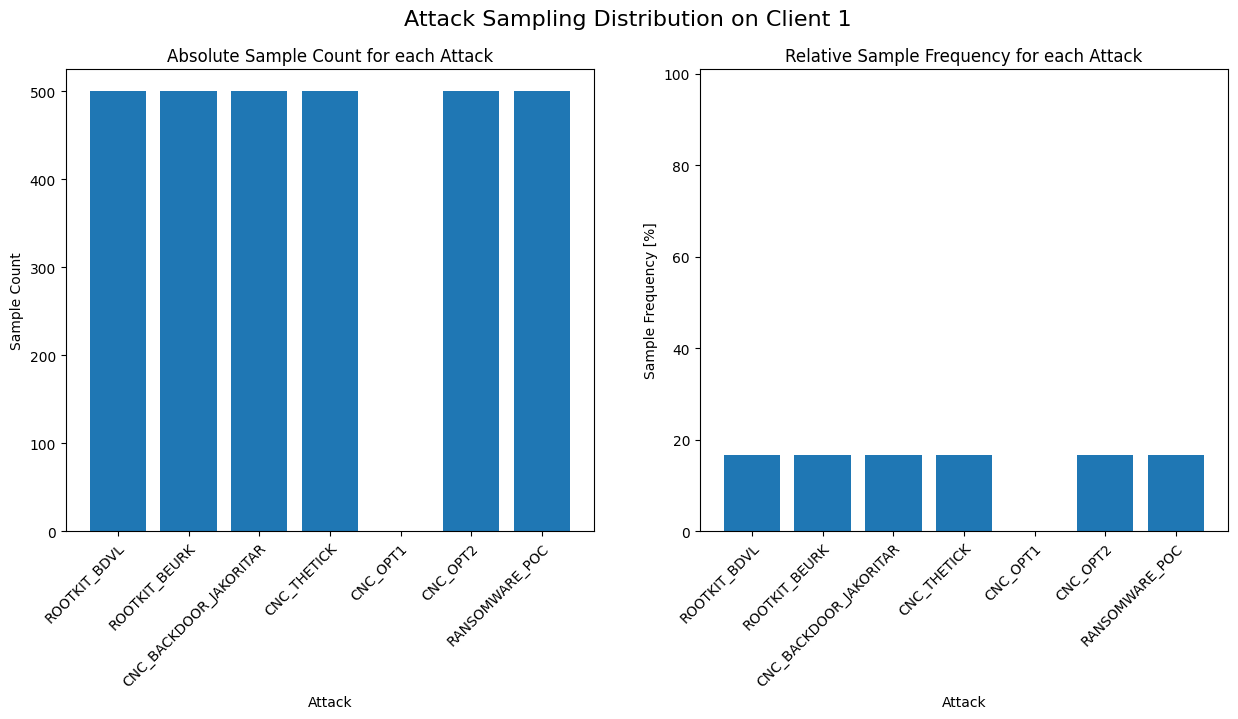

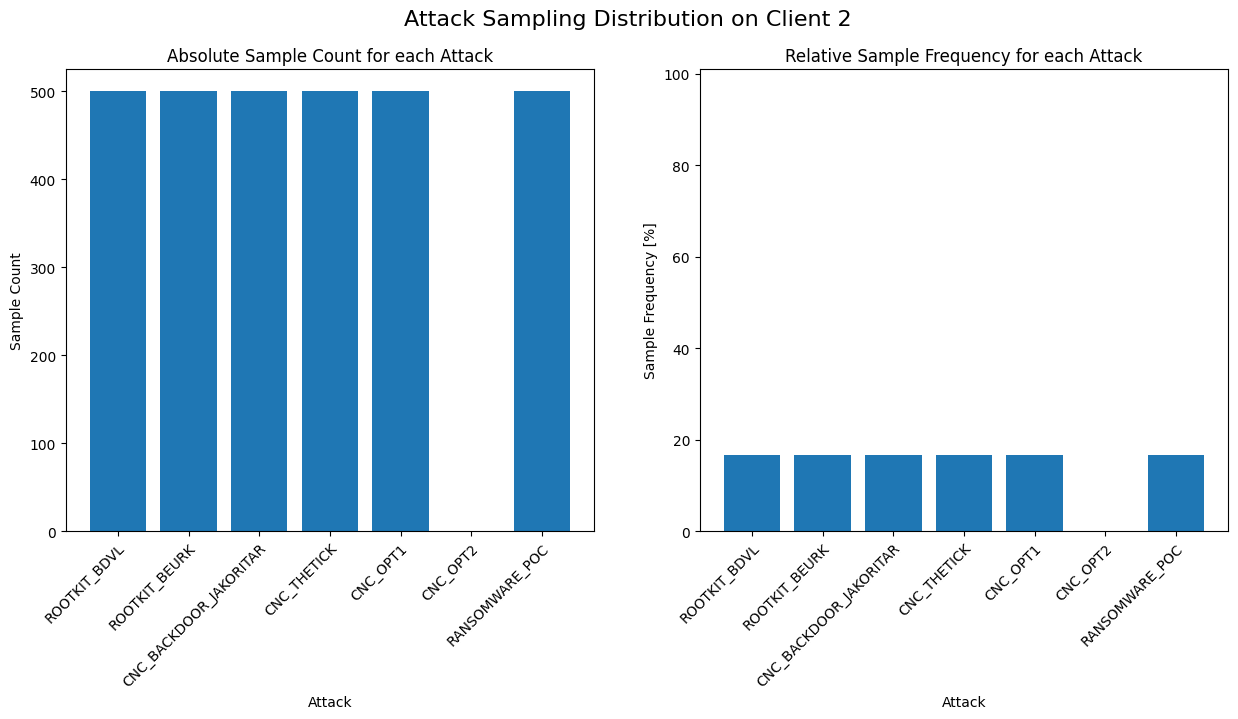

In [ ]:
p2e3v1.plot_sampling_distributions()

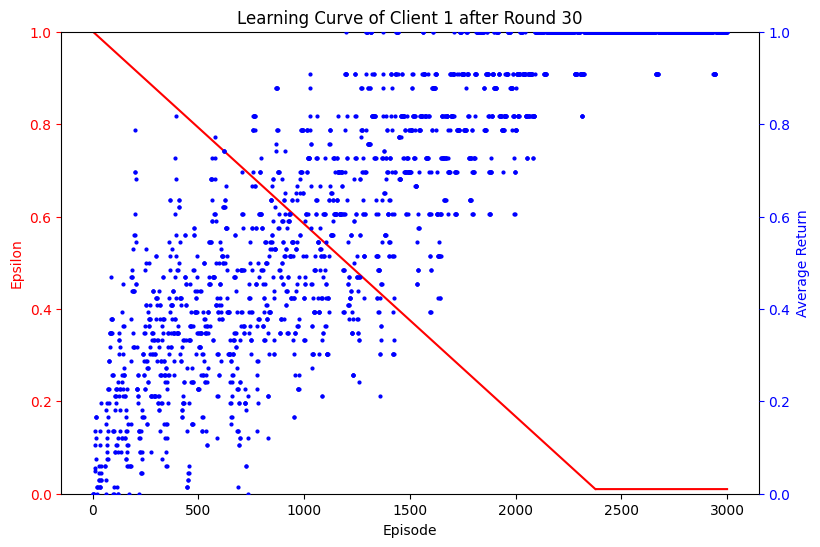

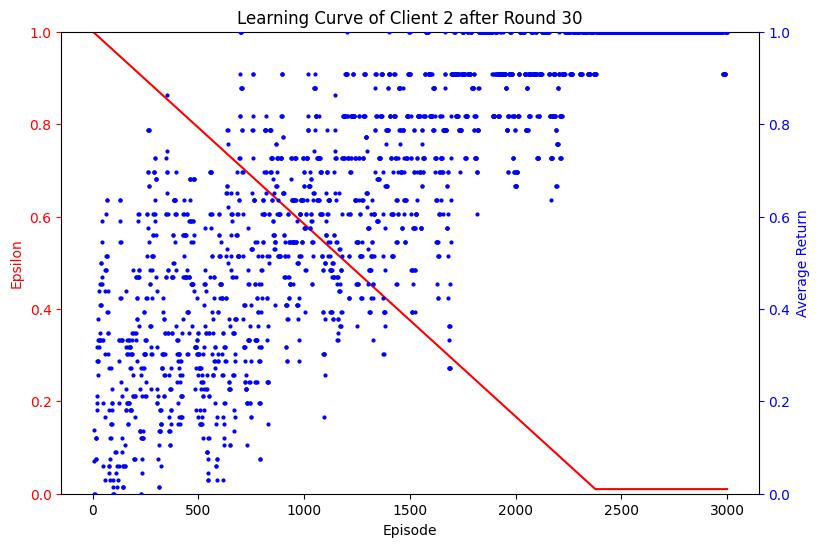

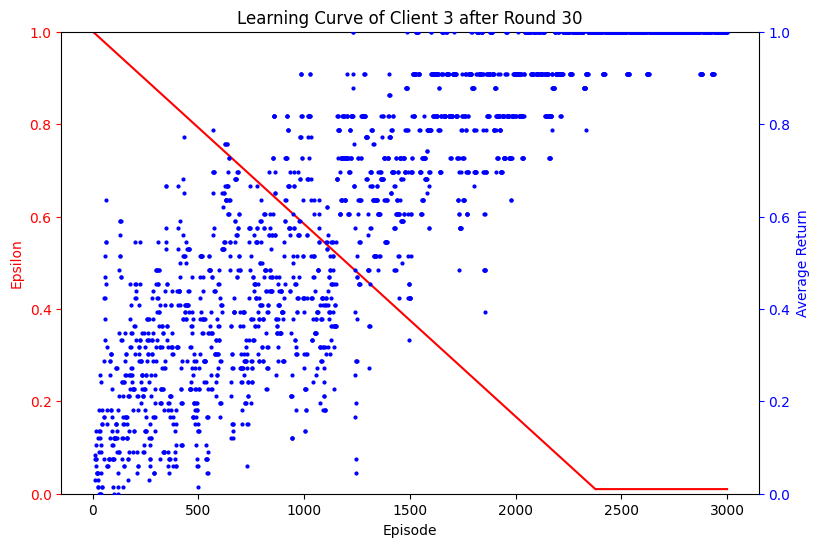

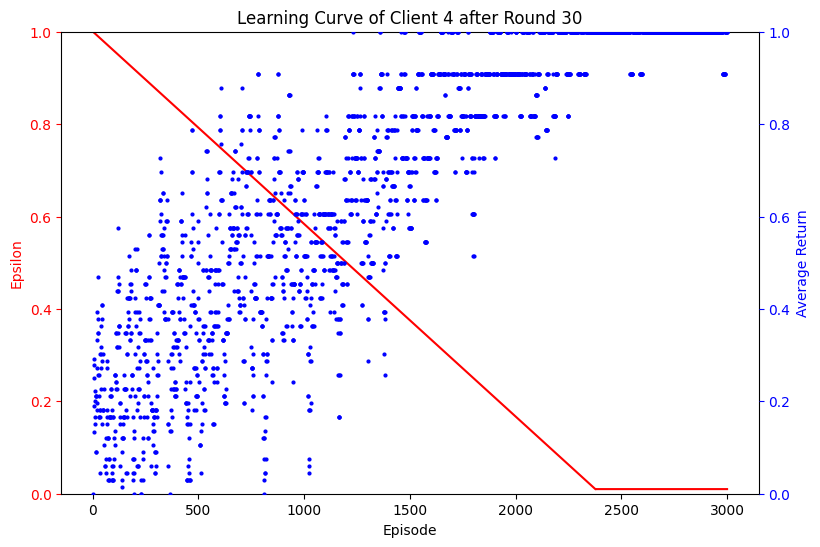

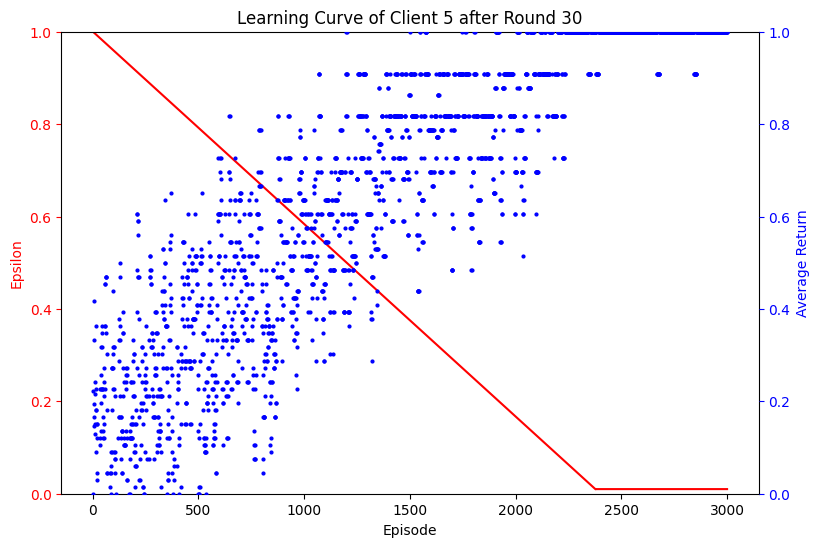

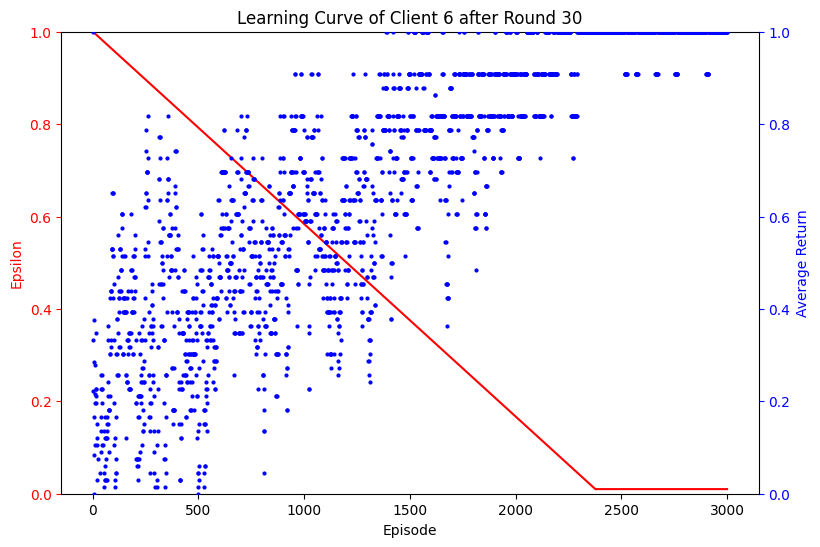

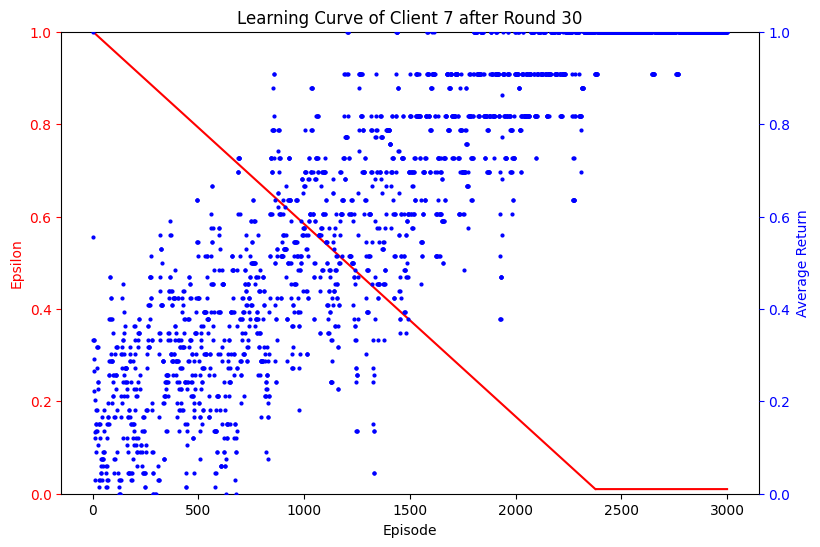

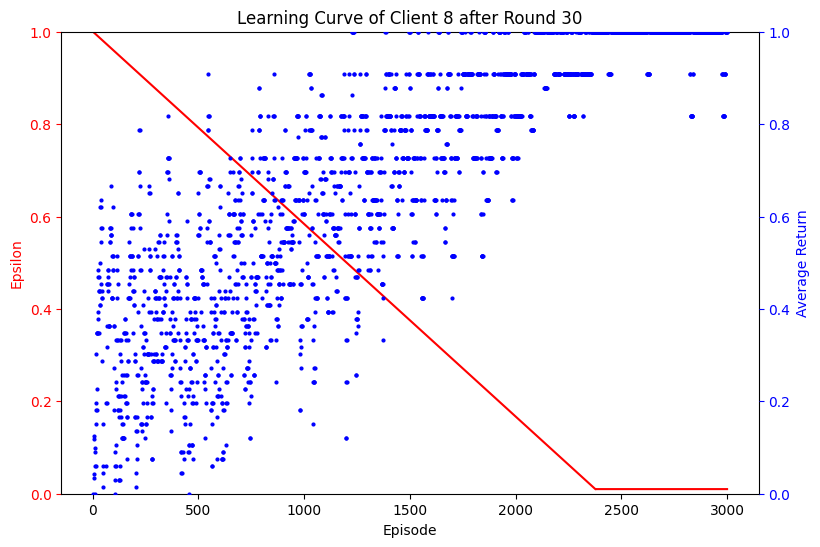

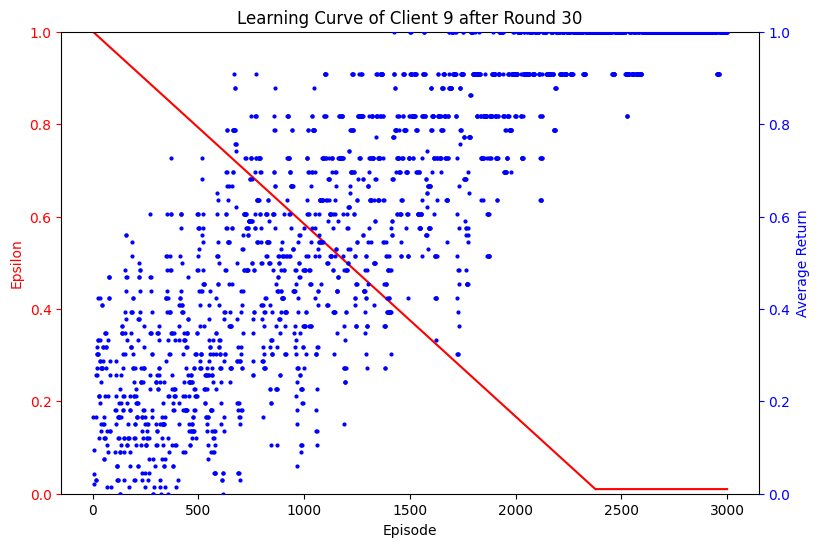

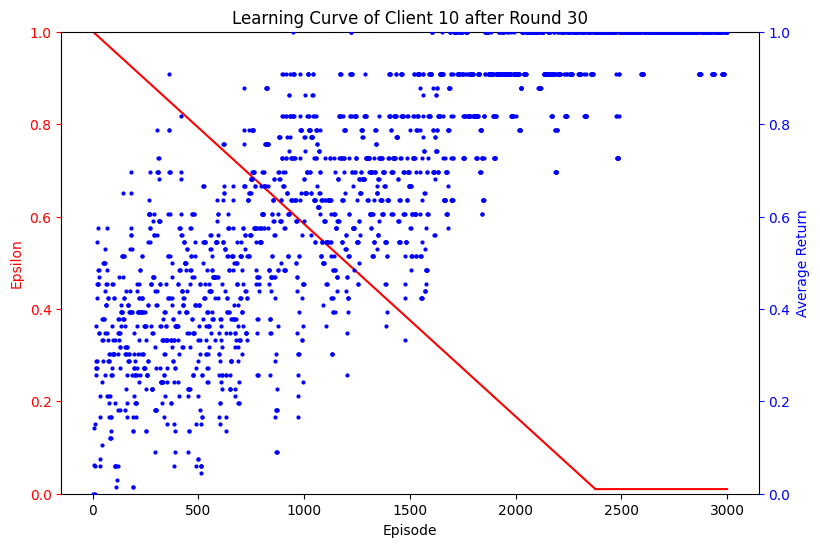

In [ ]:
p2e3v1.show_learning_curves()

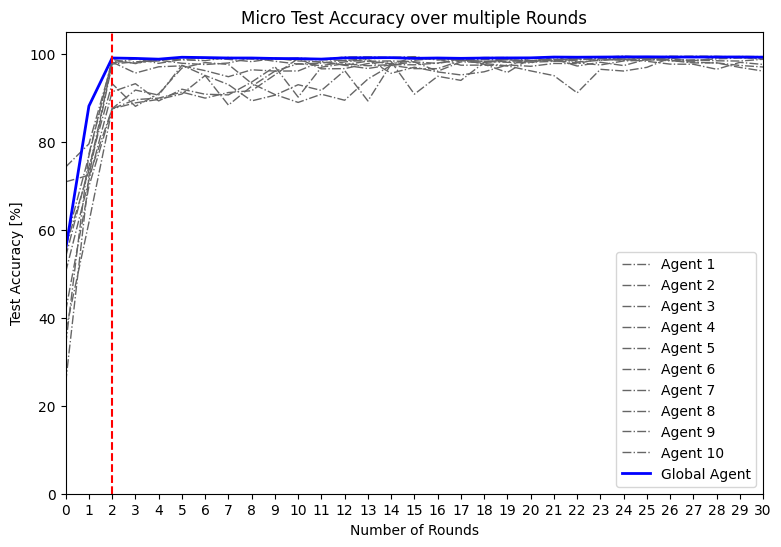

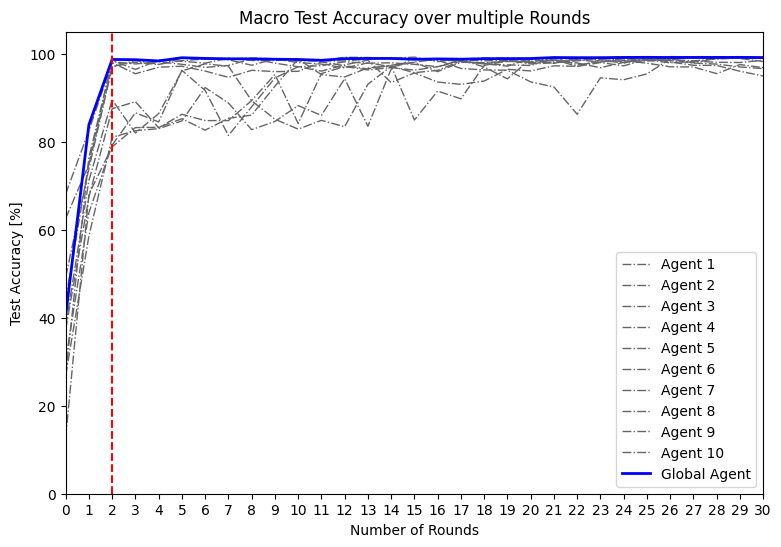

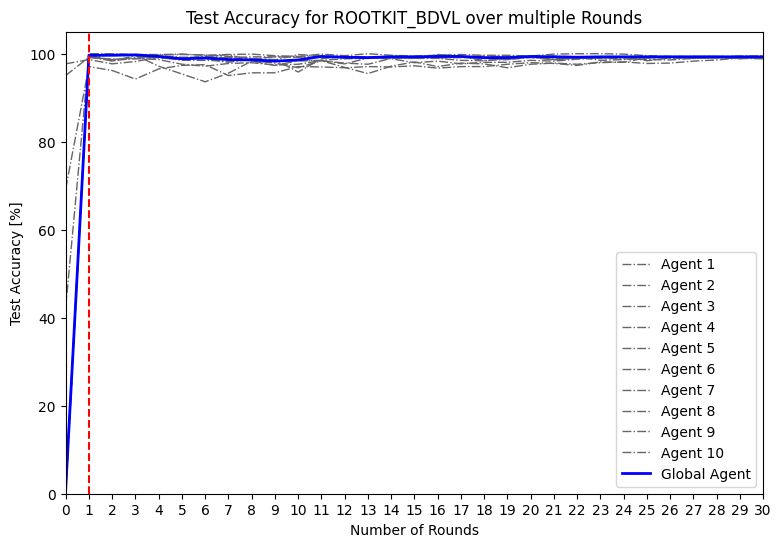

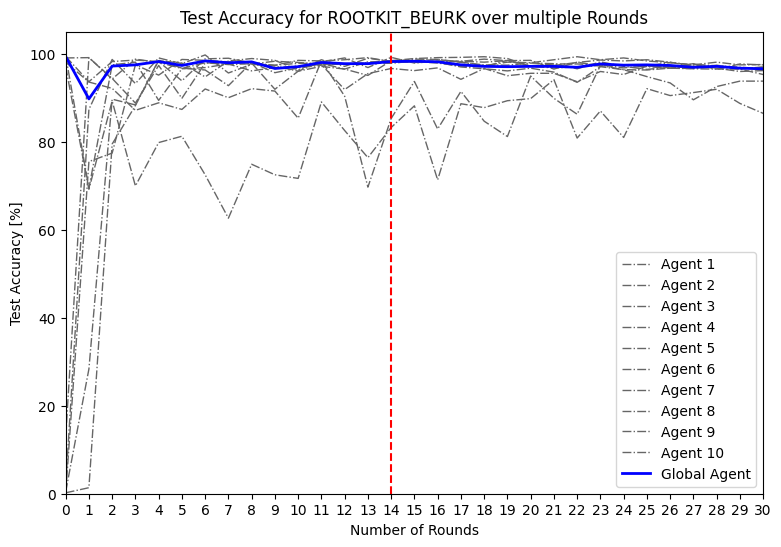

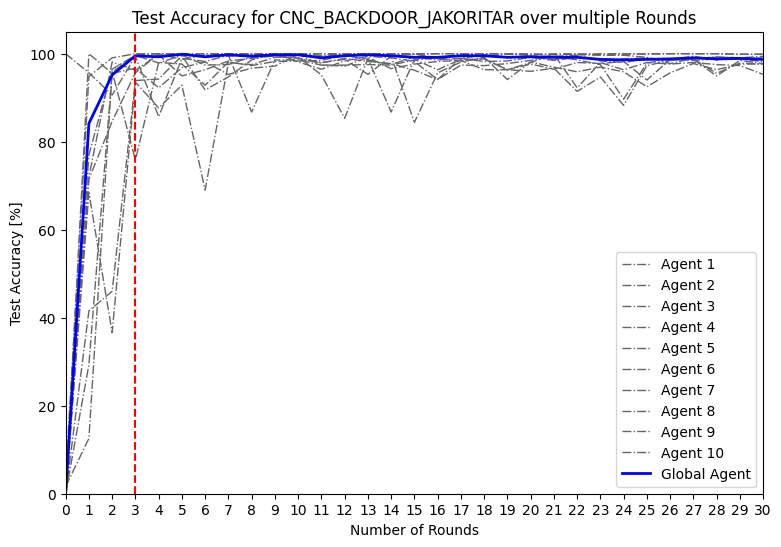

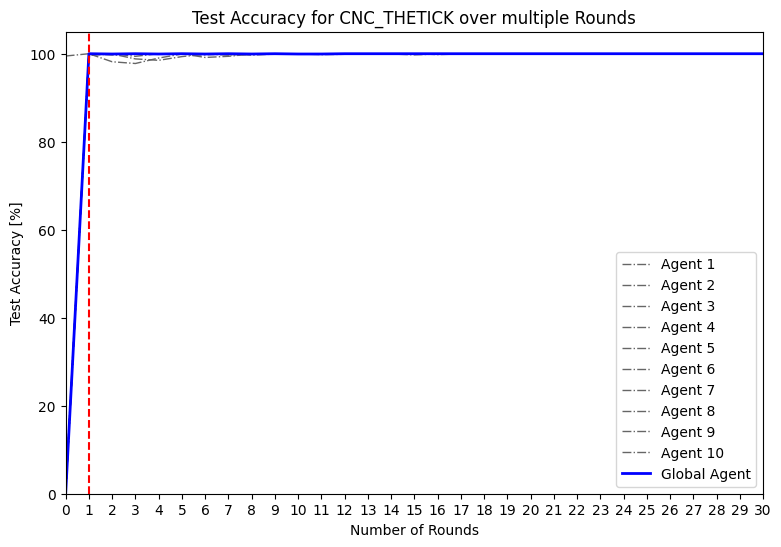

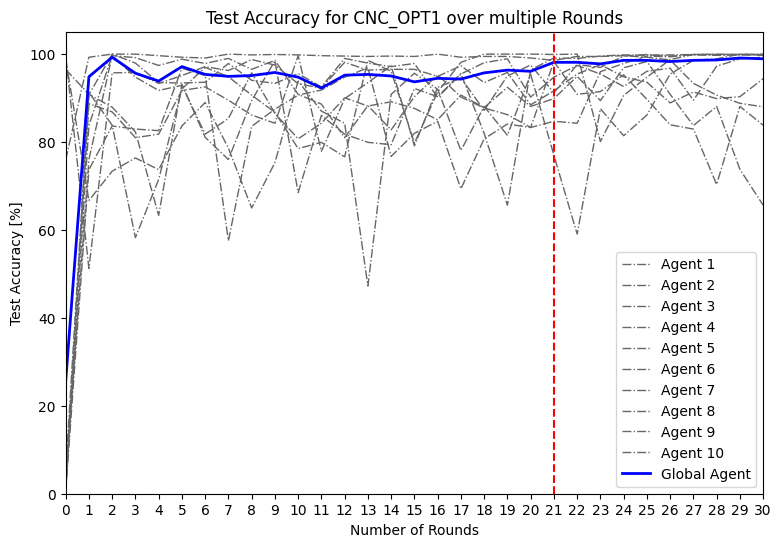

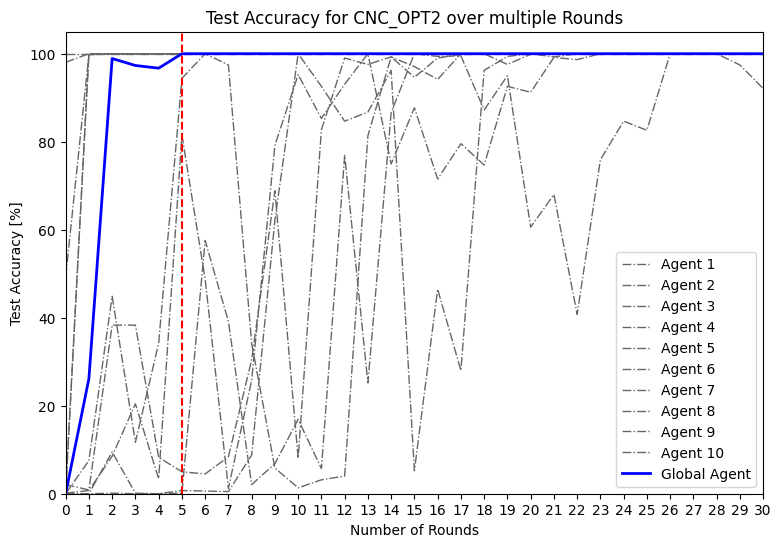

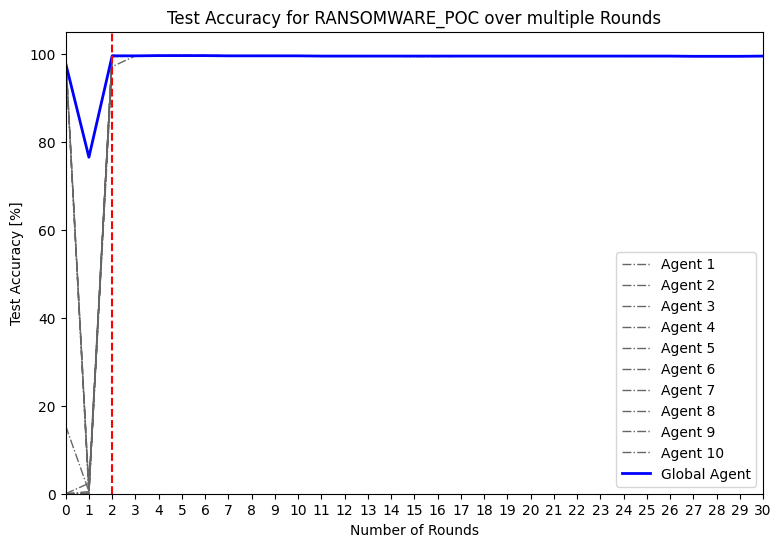

In [ ]:
p2e3v1.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=False)

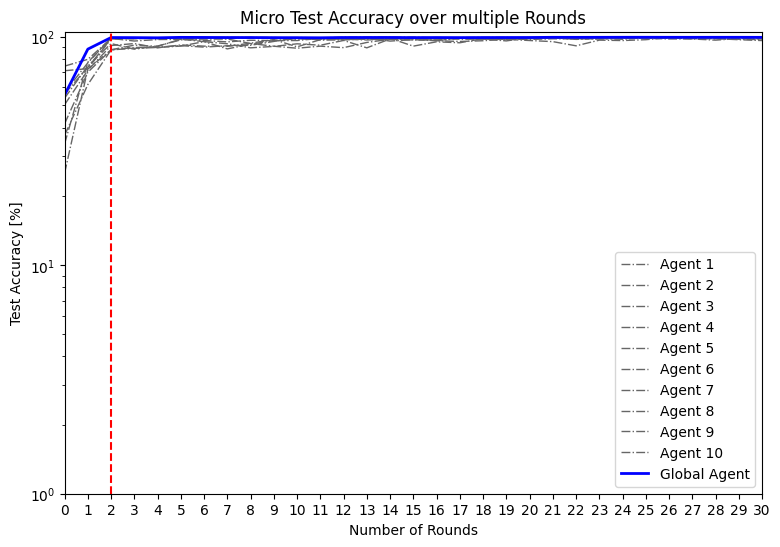

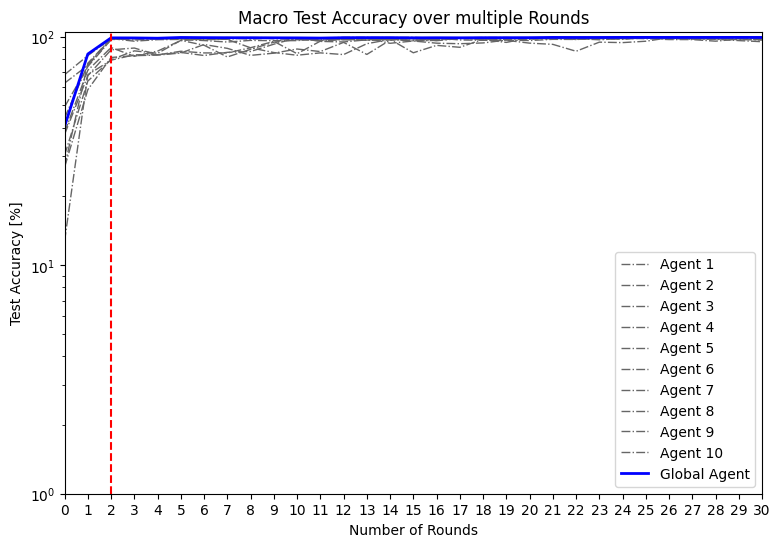

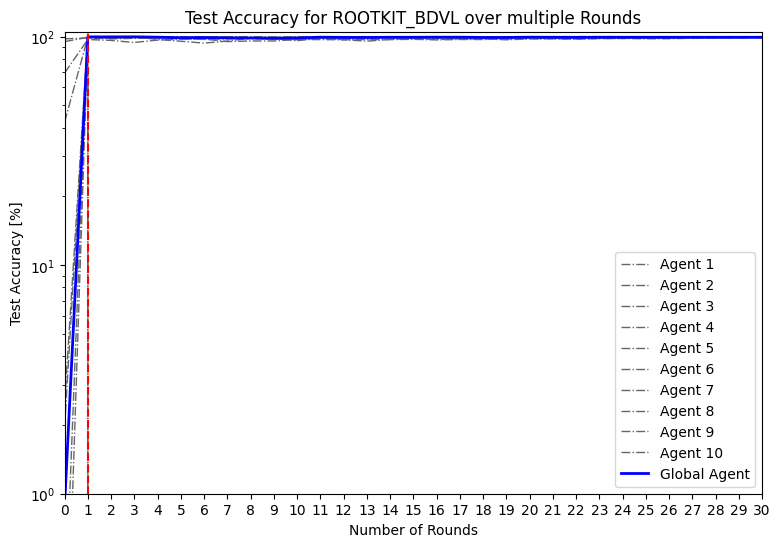

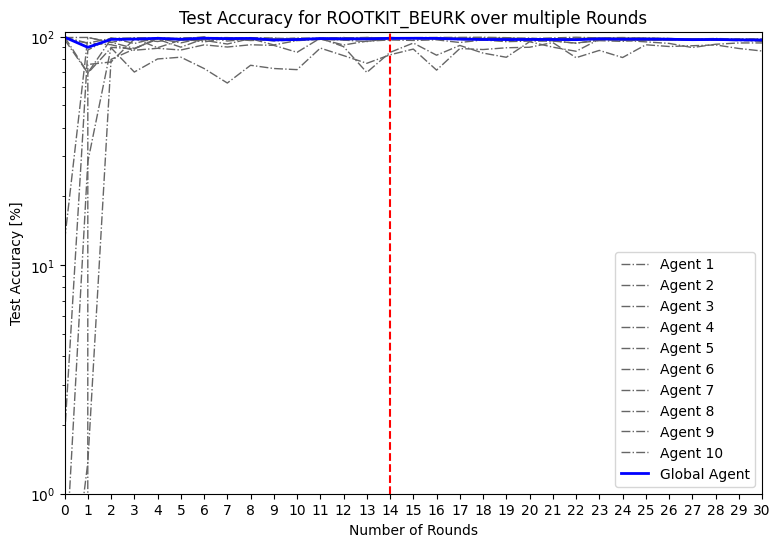

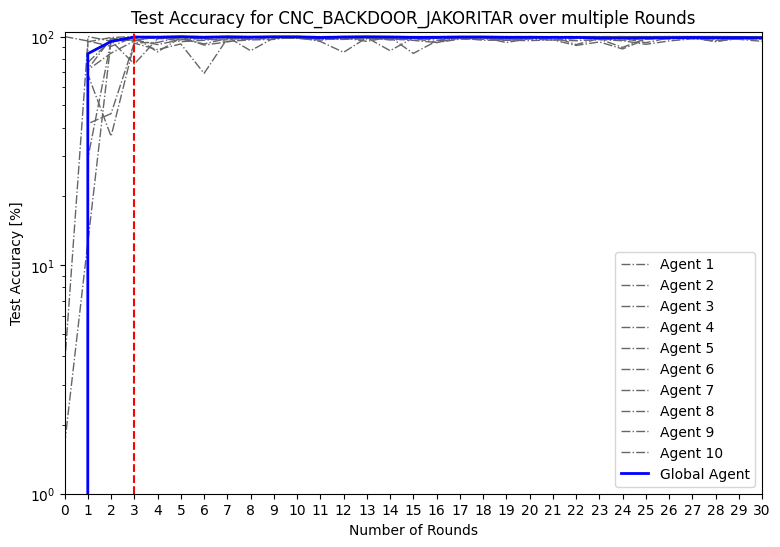

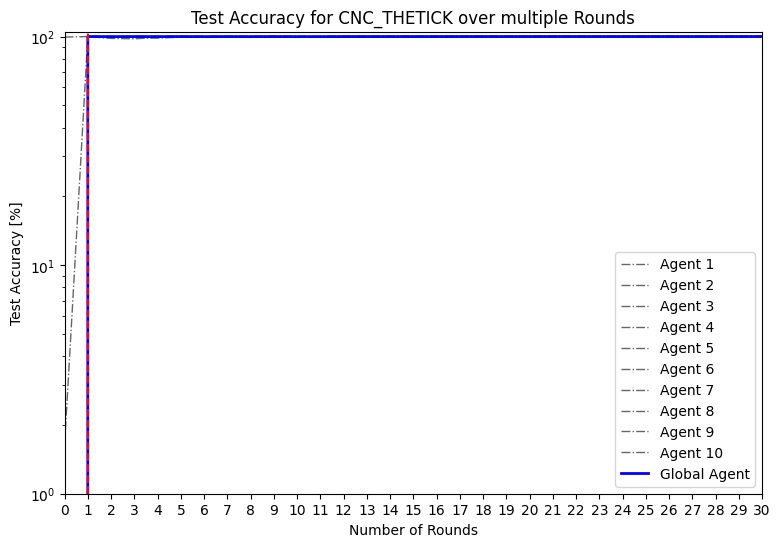

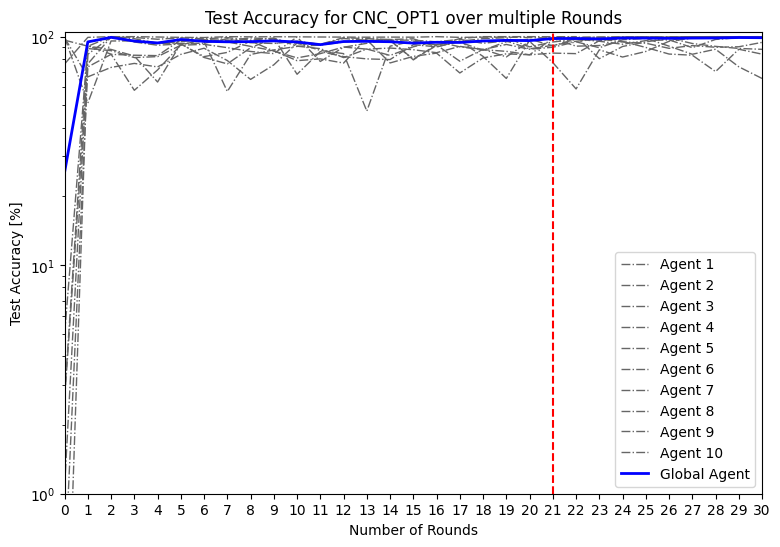

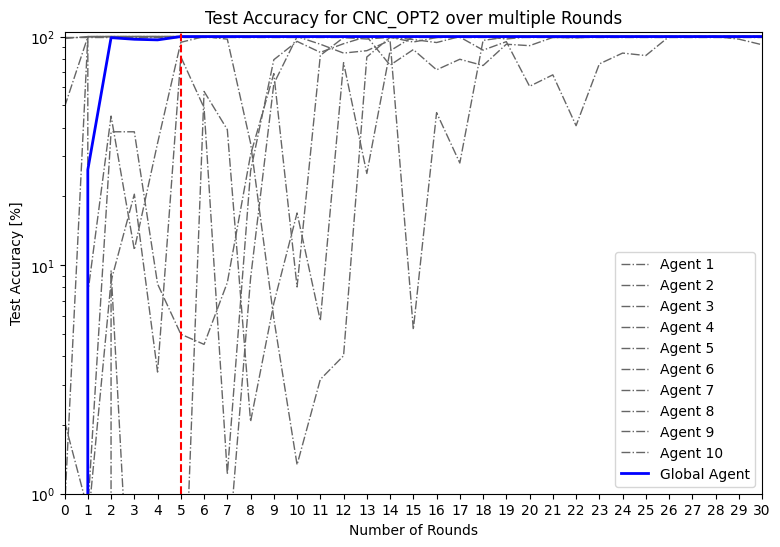

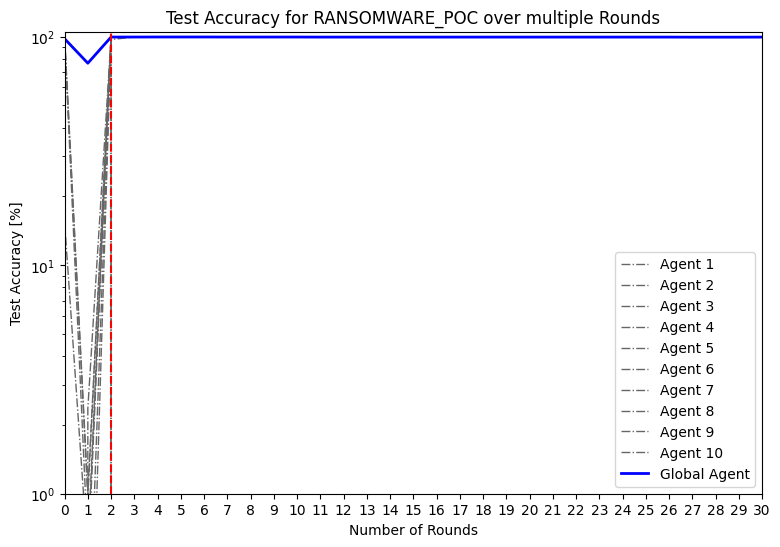

In [ ]:
p2e3v1.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=True)

---
## Experiment 2.3.2 (Medium Client Exclusive Class Setting)

In [ ]:
show_number_of_attack_samples_used(medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, 3000)

=== Absolute Number of Attack Samples used ===

--- For Clients with even ID ---
Behavior.ROOTKIT_BDVL: 600
Behavior.ROOTKIT_BEURK: 600
Behavior.CNC_BACKDOOR_JAKORITAR: 600
Behavior.CNC_THETICK: 0
Behavior.CNC_OPT1: 600
Behavior.CNC_OPT2: 0
Behavior.RANSOMWARE_POC: 600

--- For Clients with uneven ID ---
Behavior.ROOTKIT_BDVL: 600
Behavior.ROOTKIT_BEURK: 600
Behavior.CNC_BACKDOOR_JAKORITAR: 0
Behavior.CNC_THETICK: 600
Behavior.CNC_OPT1: 0
Behavior.CNC_OPT2: 600
Behavior.RANSOMWARE_POC: 600


In [ ]:
p2e3v2 = run_sample_distribution_experiment(rl_training_data_strides, test_data, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, True)



Dataset Balance Metrics: MID=0.0304 & WCS=0.8944
Evaluating local clients as well
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.95 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      66.61 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |       0    | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.C

In [ ]:
experiment_show_performance_evaluations(p2e3v2)

>>> Performance Evluations of Agent 1 over all FL Training Rounds <<<

- Agent 1 (Rounds): dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

- Agent 1 (Micro Accuracies): [0.261136712749616, 0.7138590203106332, 0.8573135347328896, 0.877026796381635, 0.8621778460488138, 0.8548387096774194, 0.8643966547192353, 0.8483529612561871, 0.8557774364225977, 0.8526199010069978, 0.8614951356886841, 0.8745519713261649, 0.8879501621437106, 0.8901689708141322, 0.8620071684587813, 0.8899129544290835, 0.8995562382659157, 0.9139784946236559, 0.9086874893326506, 0.9058713090971156, 0.9153439153439153, 0.882573818057689, 0.8955453149001537, 0.9023724185014508, 0.8913637139443591, 0.9073220686123912, 0.9073220686123912, 0.9078341013824884, 0.9011776753712237, 0.910394265232975, 0.9037378392217101]

- Agent 1 (Macro Accuracies):: [0.13902207696385505, 0.6798241972940529, 0.7851836345122507, 0.8105853204028194, 0.7912860999636906, 0

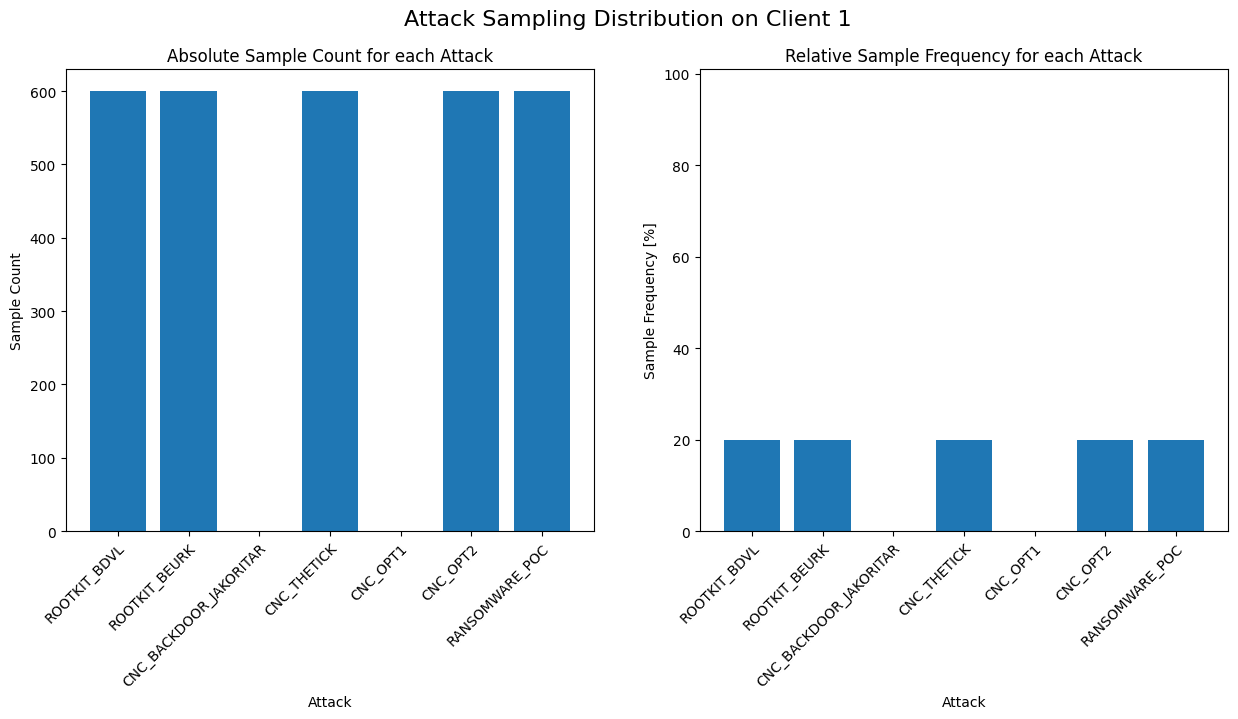

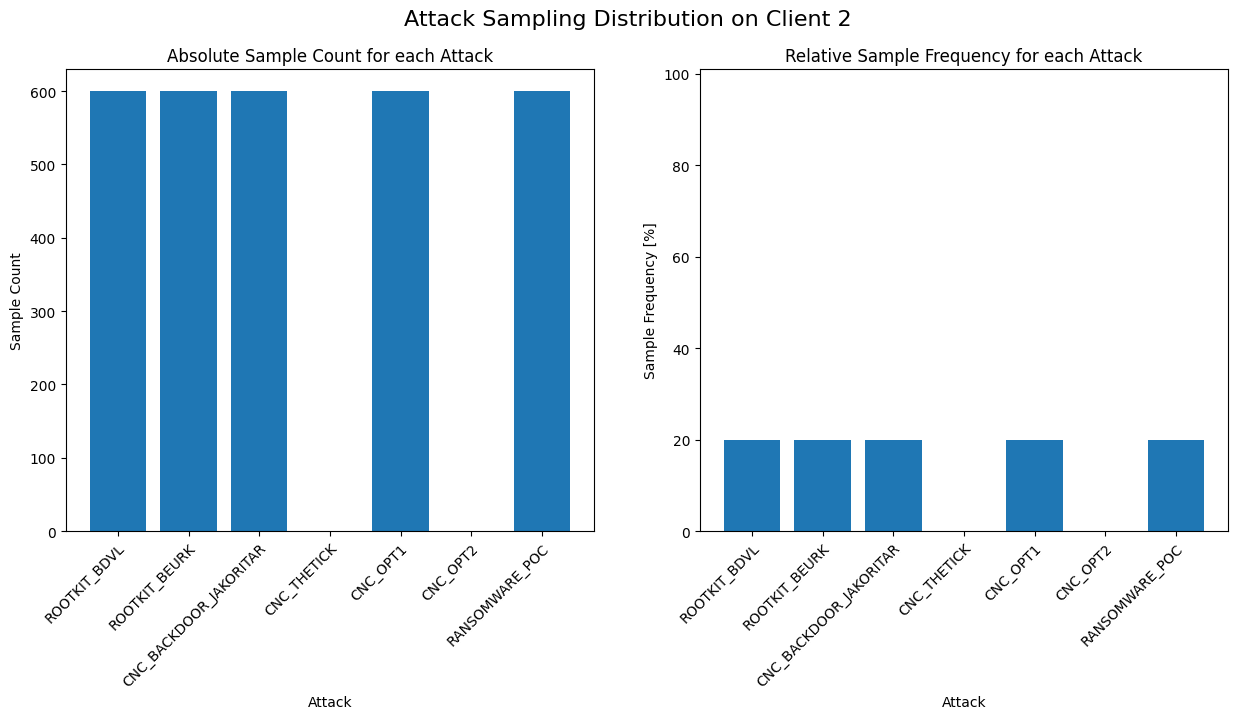

In [ ]:
p2e3v2.plot_sampling_distributions()

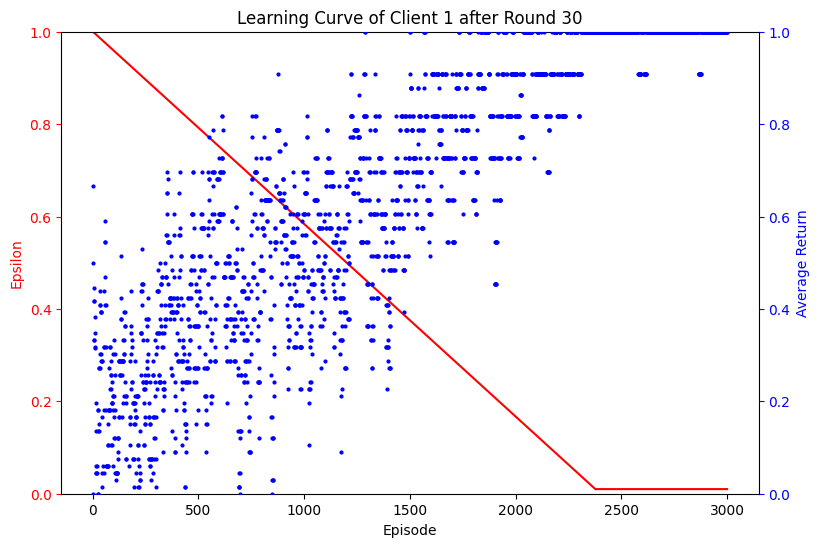

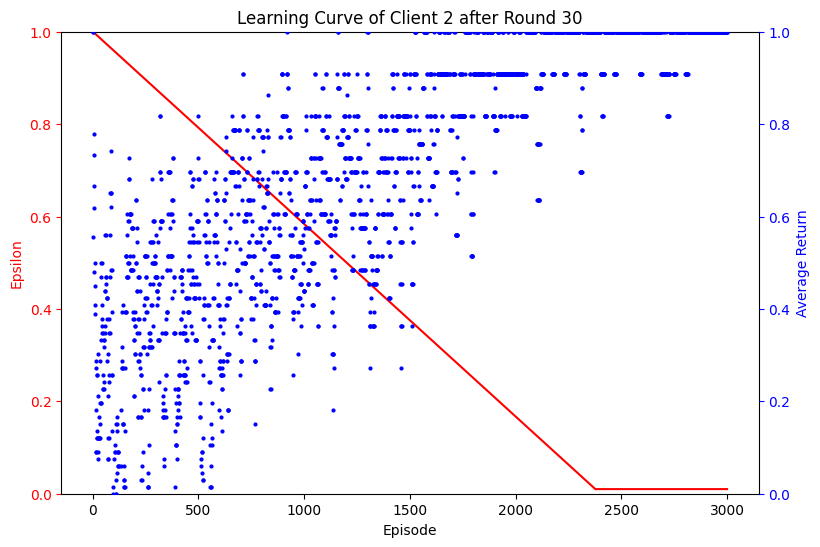

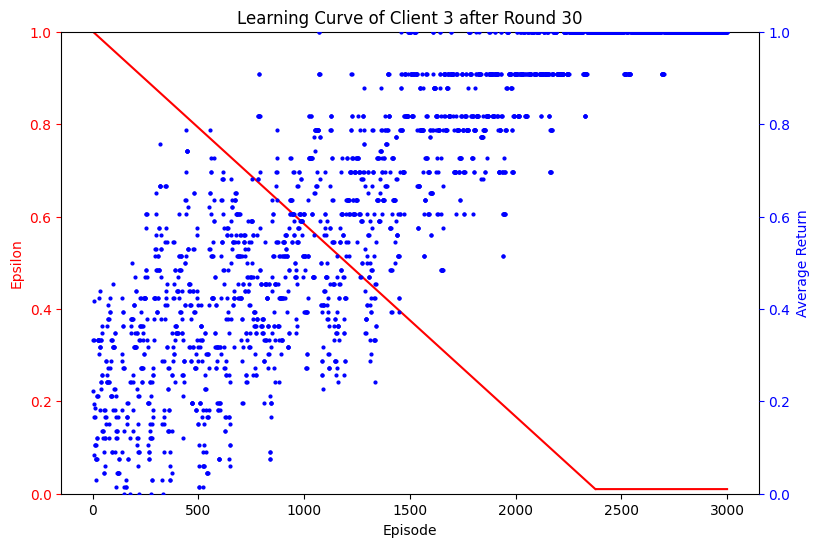

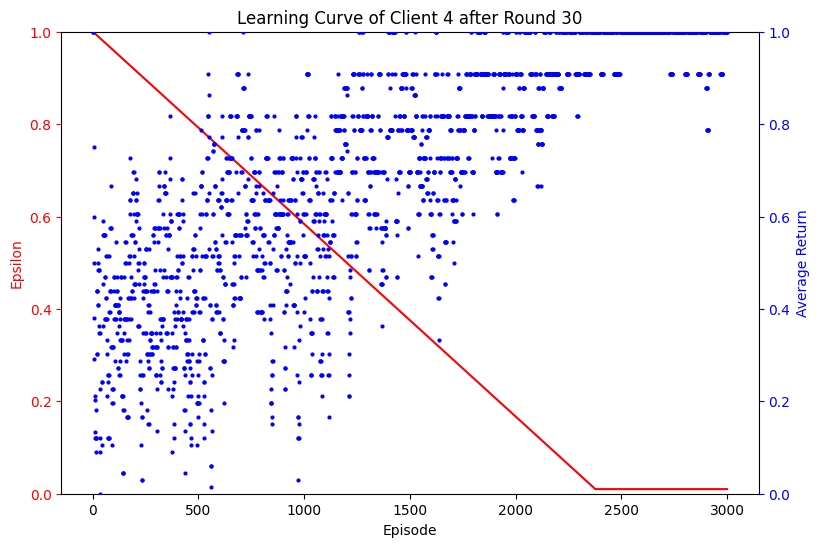

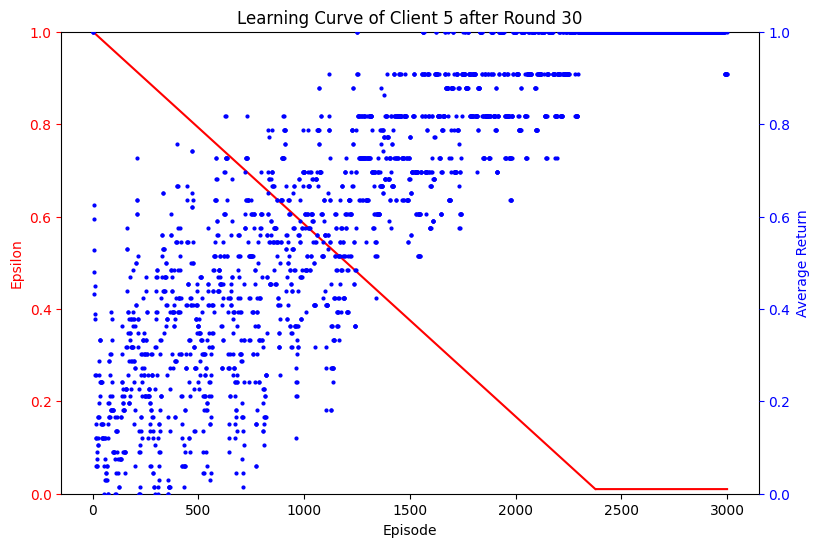

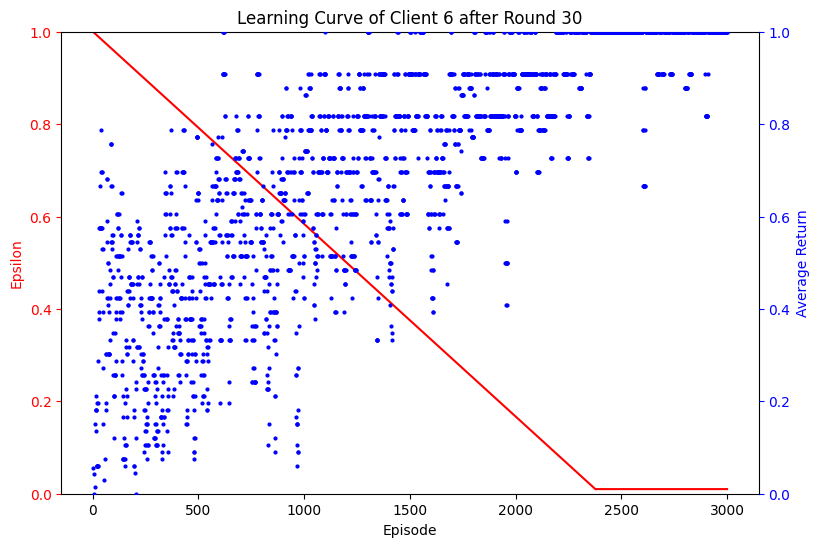

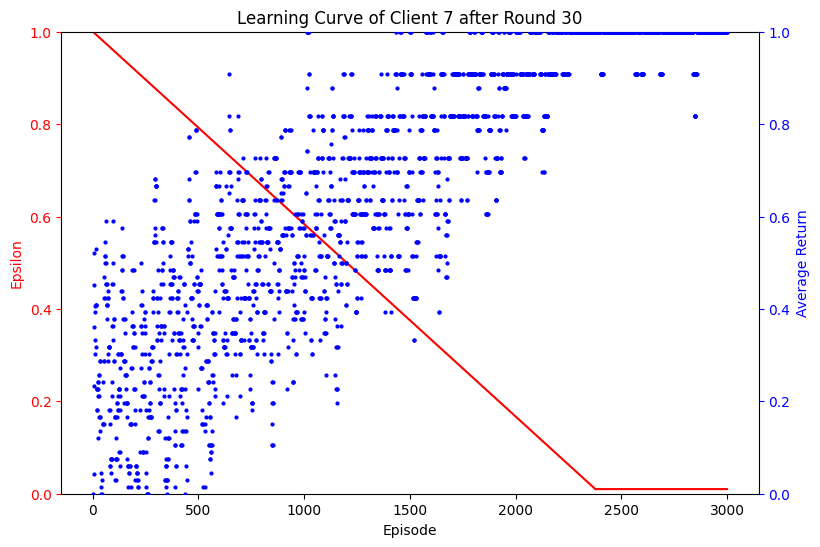

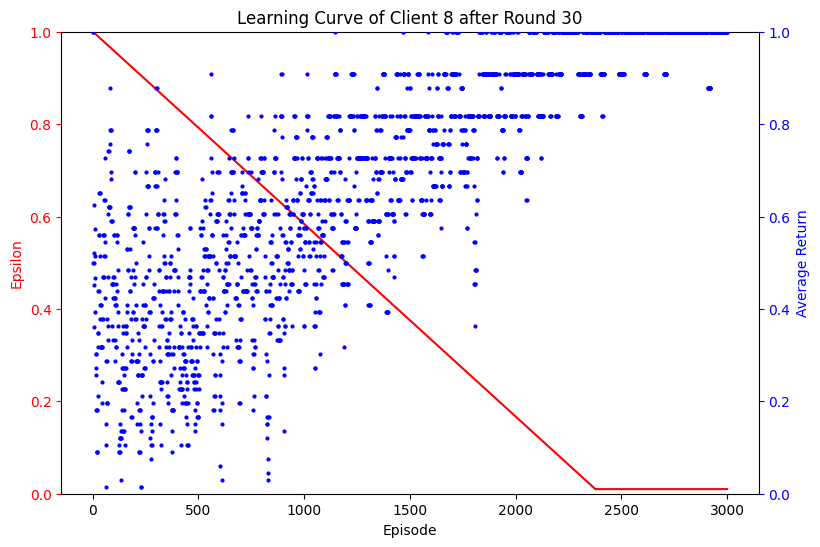

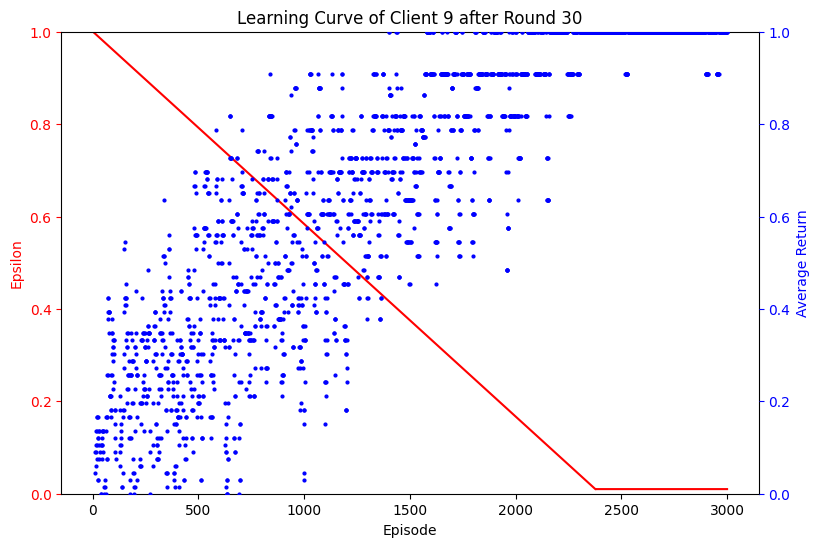

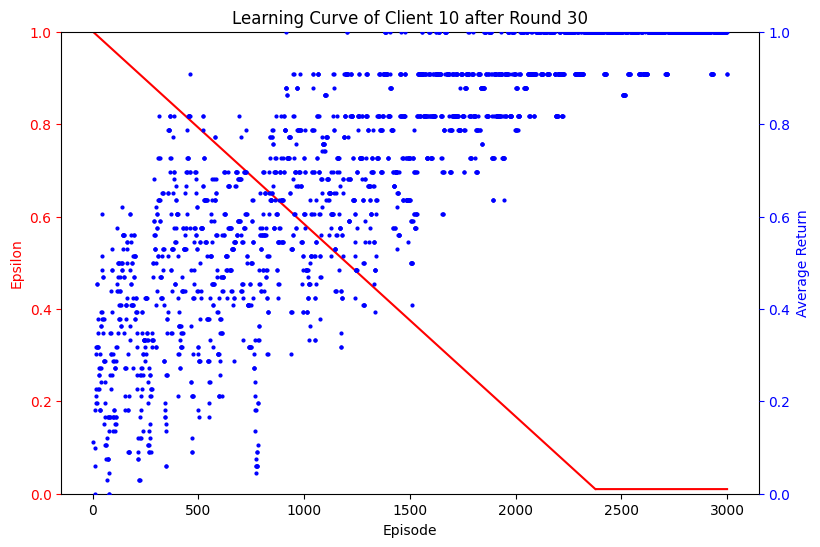

In [ ]:
p2e3v2.show_learning_curves()

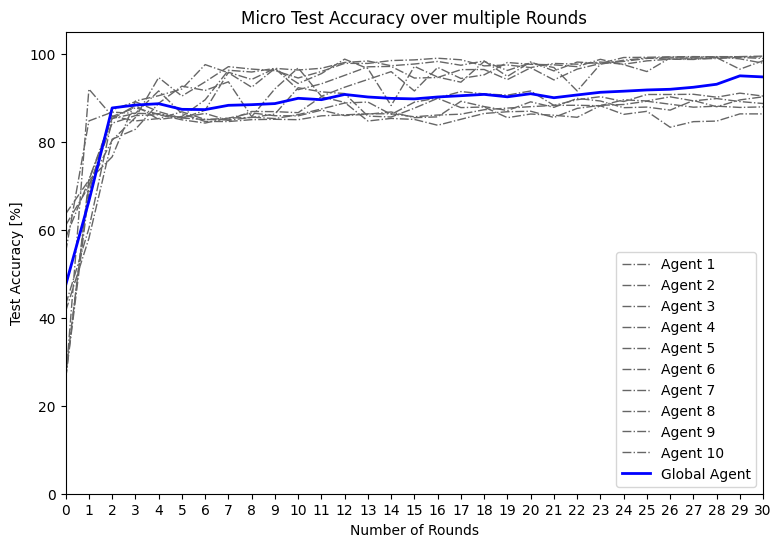

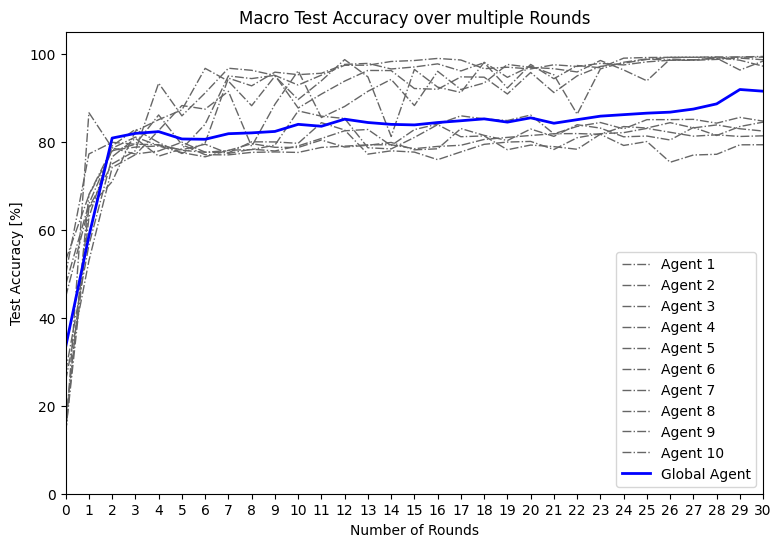

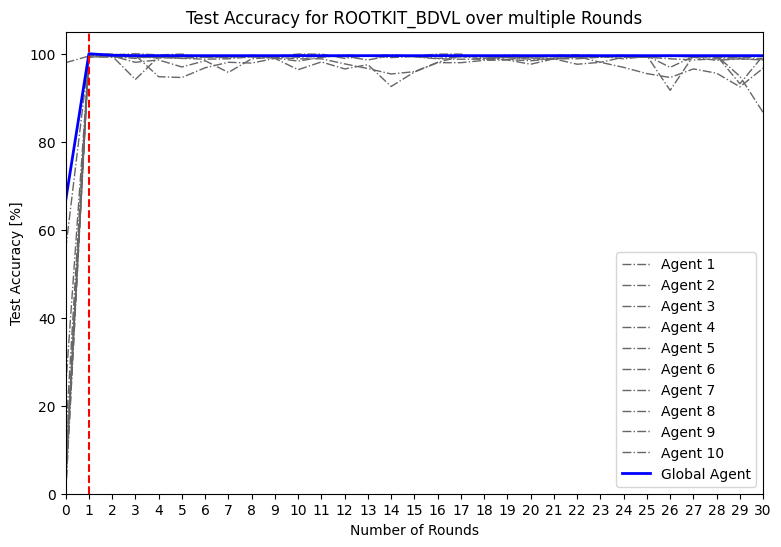

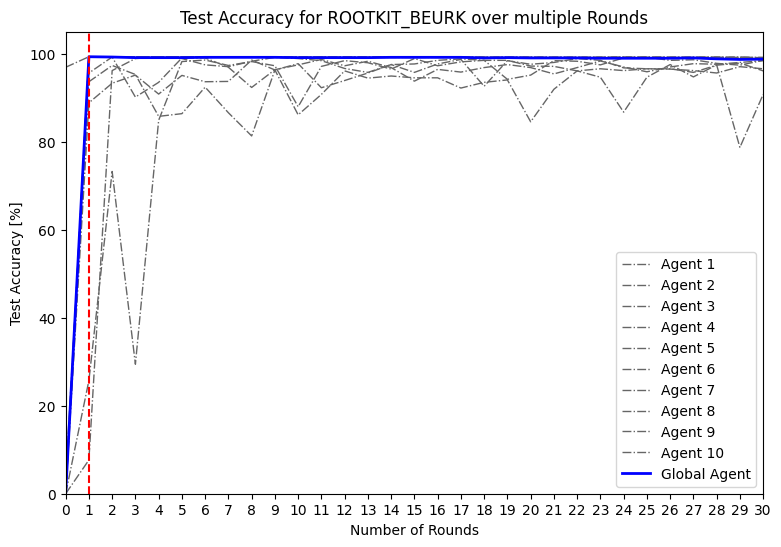

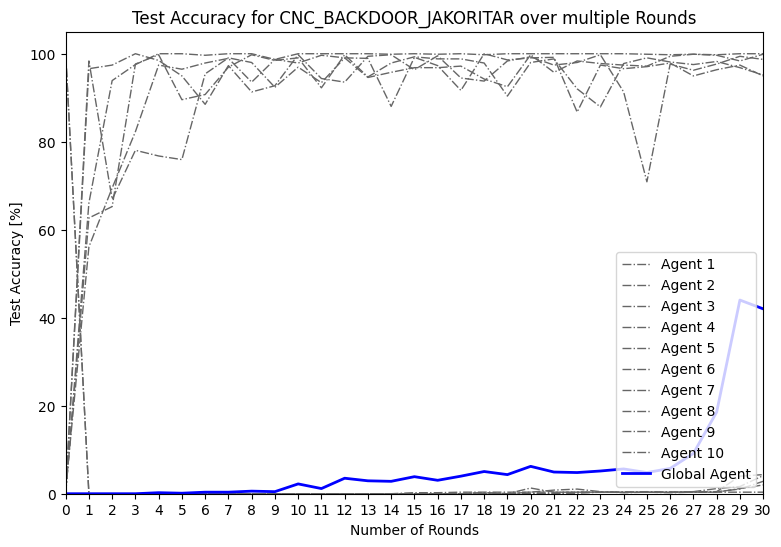

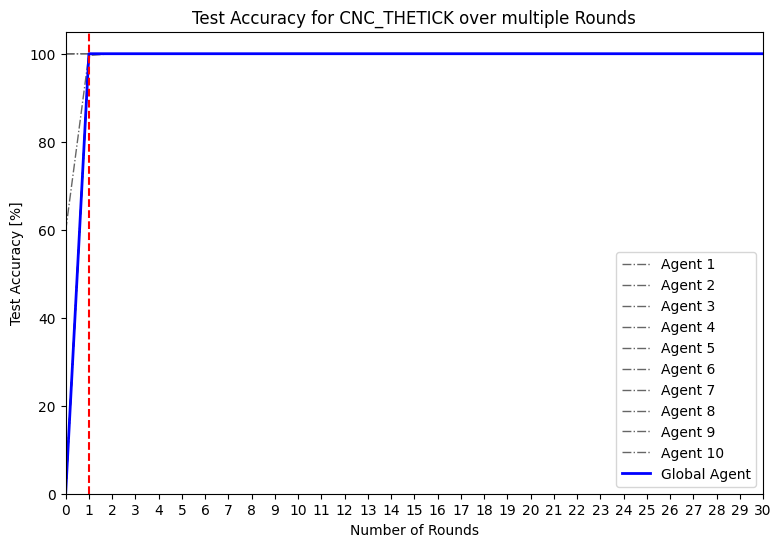

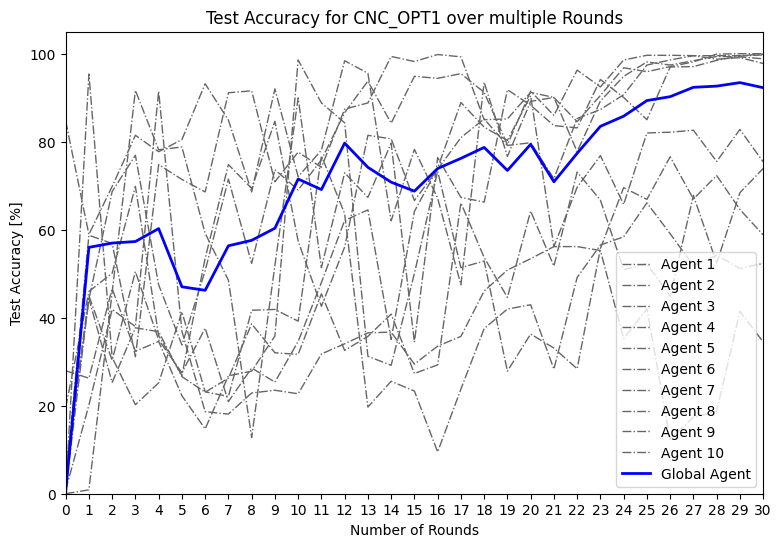

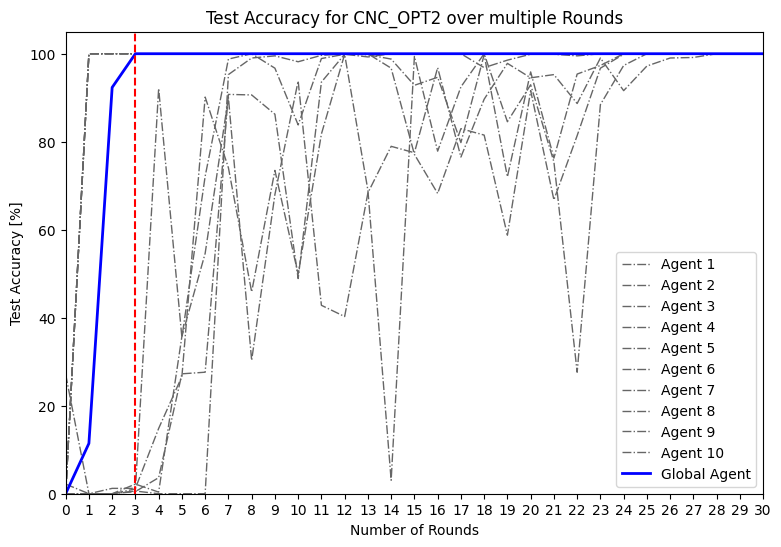

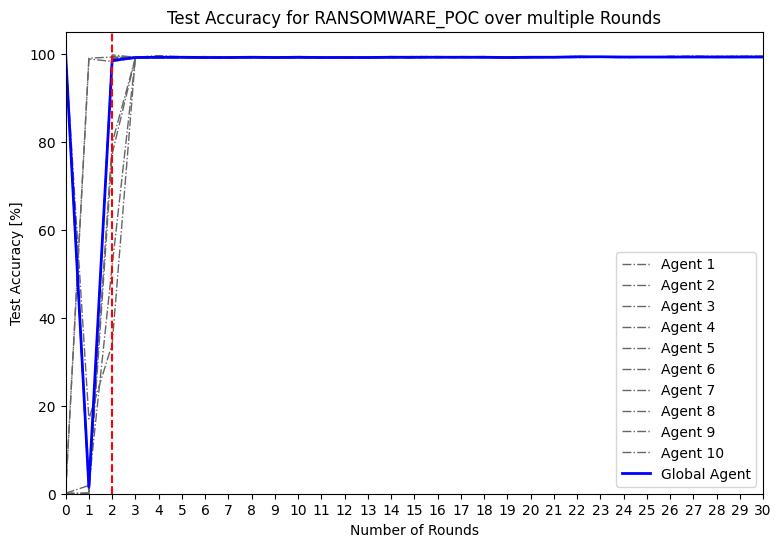

In [ ]:
p2e3v2.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=False)

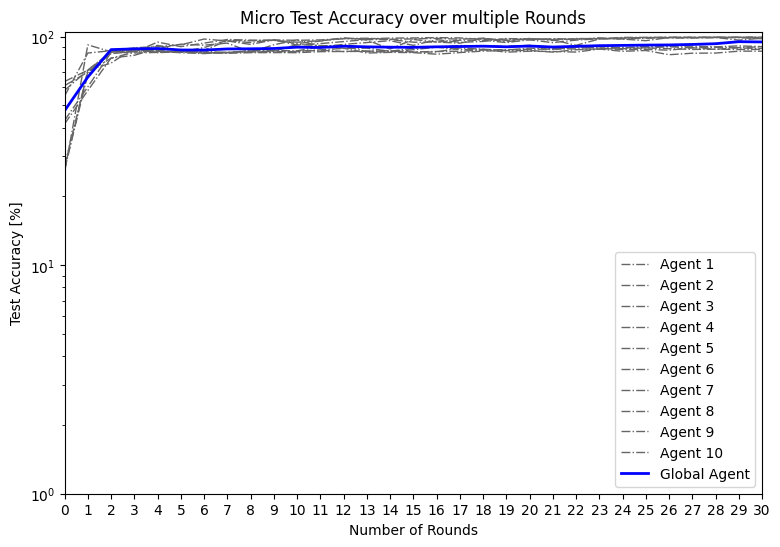

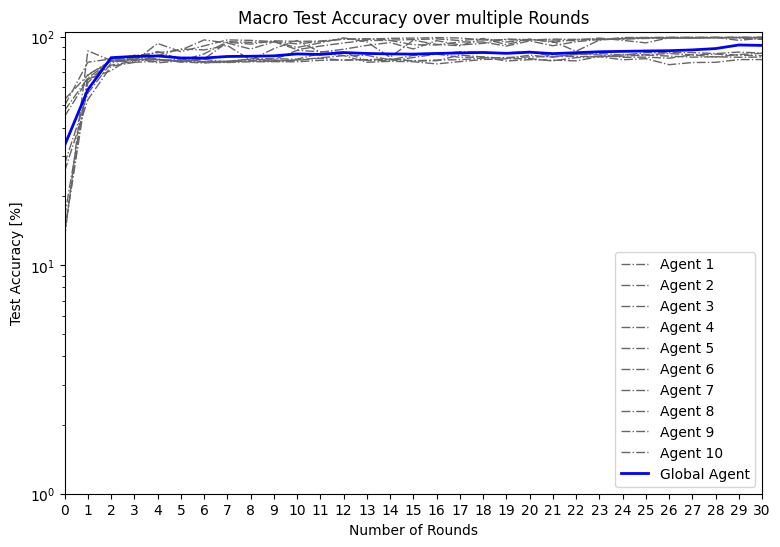

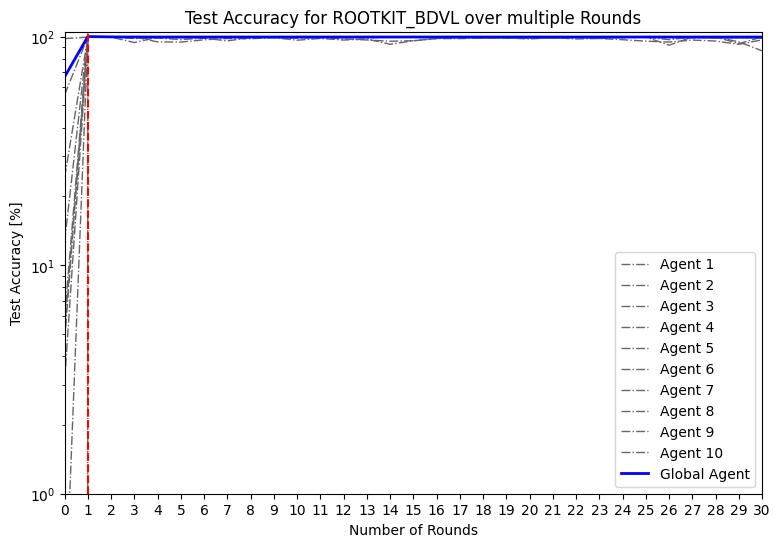

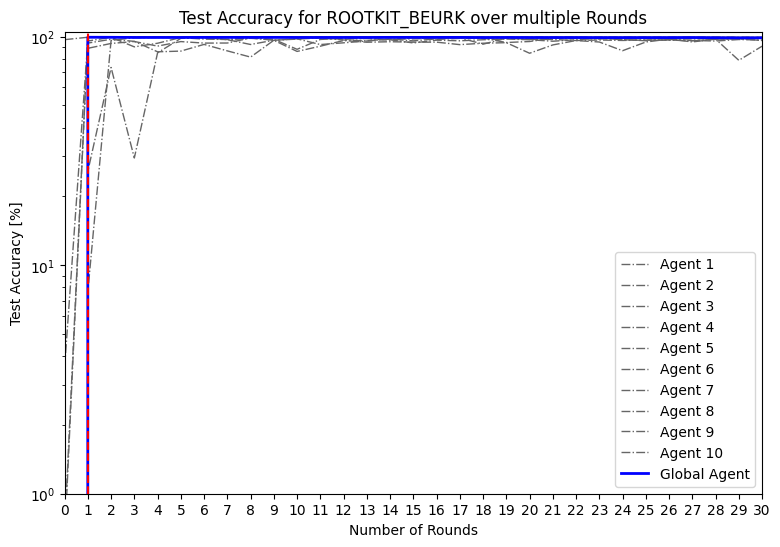

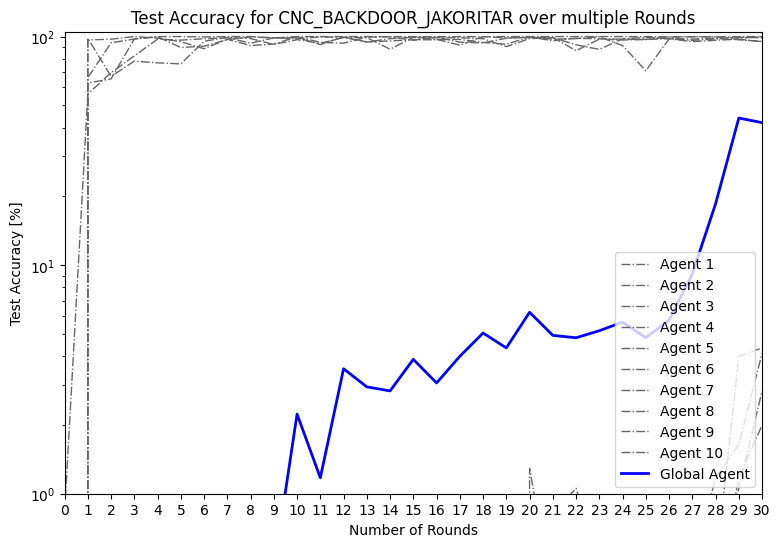

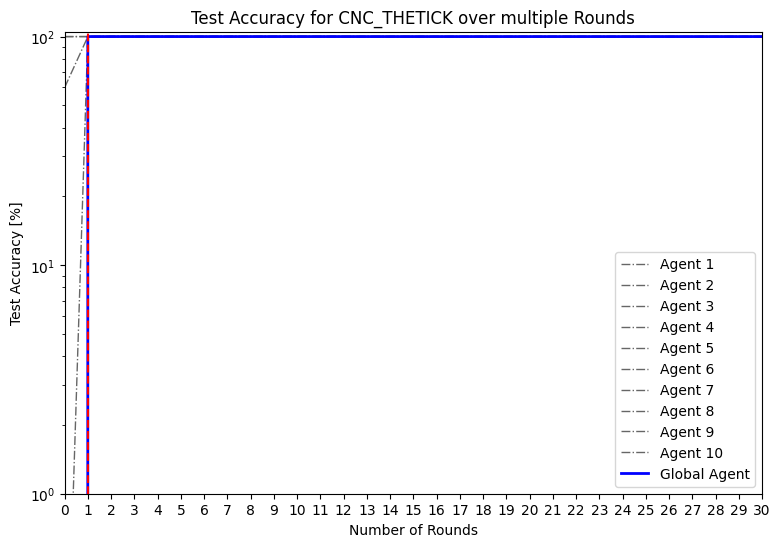

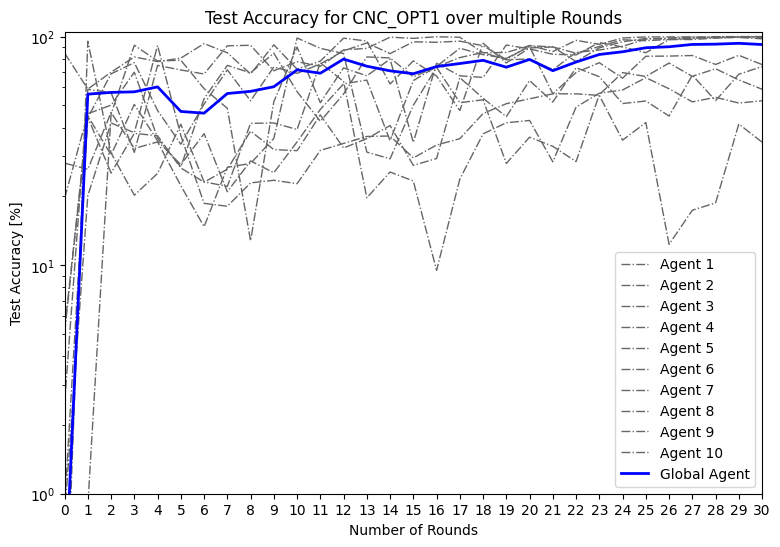

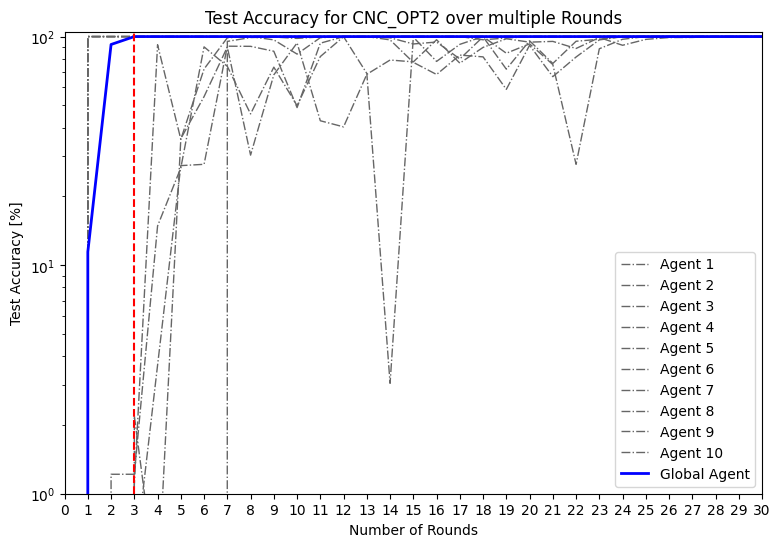

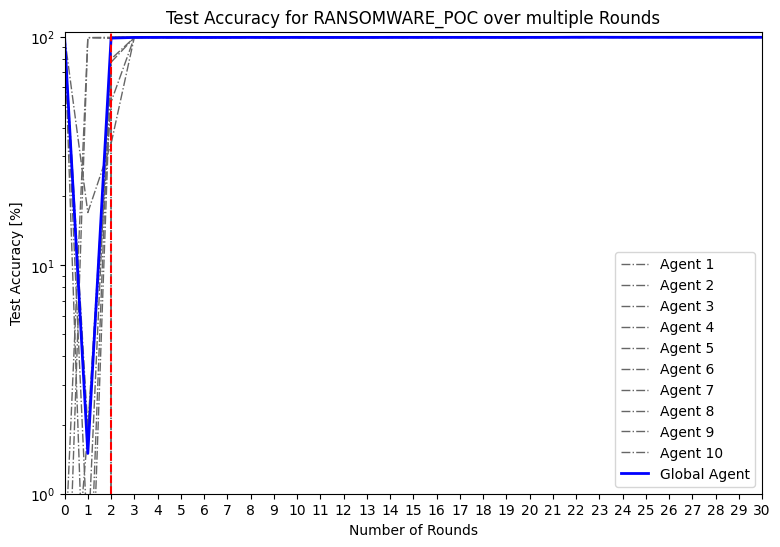

In [ ]:
p2e3v2.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=True)

---
## Experiment 2.3.3 (Strong Client Exclusive Class Setting)

In [ ]:
show_number_of_attack_samples_used(strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02, 3000)


=== Absolute Number of Attack Samples used ===

--- For Clients with even ID ---
Behavior.ROOTKIT_BDVL: 750
Behavior.ROOTKIT_BEURK: 0
Behavior.CNC_BACKDOOR_JAKORITAR: 750
Behavior.CNC_THETICK: 0
Behavior.CNC_OPT1: 750
Behavior.CNC_OPT2: 0
Behavior.RANSOMWARE_POC: 750

--- For Clients with uneven ID ---
Behavior.ROOTKIT_BDVL: 0
Behavior.ROOTKIT_BEURK: 1000
Behavior.CNC_BACKDOOR_JAKORITAR: 0
Behavior.CNC_THETICK: 1000
Behavior.CNC_OPT1: 0
Behavior.CNC_OPT2: 1000
Behavior.RANSOMWARE_POC: 0


In [ ]:
p2e3v3 = run_sample_distribution_experiment(rl_training_data_strides, test_data, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, True)



Dataset Balance Metrics: MID=0.0053 & WCS=0.7053
Evaluating local clients as well
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.64 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      19.49 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |       0.07 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0.07 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.C

In [ ]:
experiment_show_performance_evaluations(p2e3v3)

>>> Performance Evluations of Agent 1 over all FL Training Rounds <<<

- Agent 1 (Rounds): dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

- Agent 1 (Micro Accuracies): [0.3226659839563065, 0.830005120327701, 0.8301757979177334, 0.6715309779825909, 0.8243727598566308, 0.8289810547875064, 0.8291517323775388, 0.8249701314217444, 0.8149854924048472, 0.830005120327701, 0.7327188940092166, 0.8269329237071172, 0.8250554702167605, 0.8285543608124253, 0.8287250384024577, 0.8291517323775388, 0.8293224099675712, 0.828810377197474, 0.8294930875576036, 0.8294930875576036, 0.8294930875576036, 0.8289810547875064, 0.8294930875576036, 0.8290663935825227, 0.8286396996074415, 0.8293224099675712, 0.8285543608124253, 0.671189622802526, 0.8150708311998635, 0.7866530124594641, 0.8172043010752689]

- Agent 1 (Macro Accuracies):: [0.2214548084133634, 0.7491127829000077, 0.7493785364823019, 0.6248288843258043, 0.7448047685701773, 0.

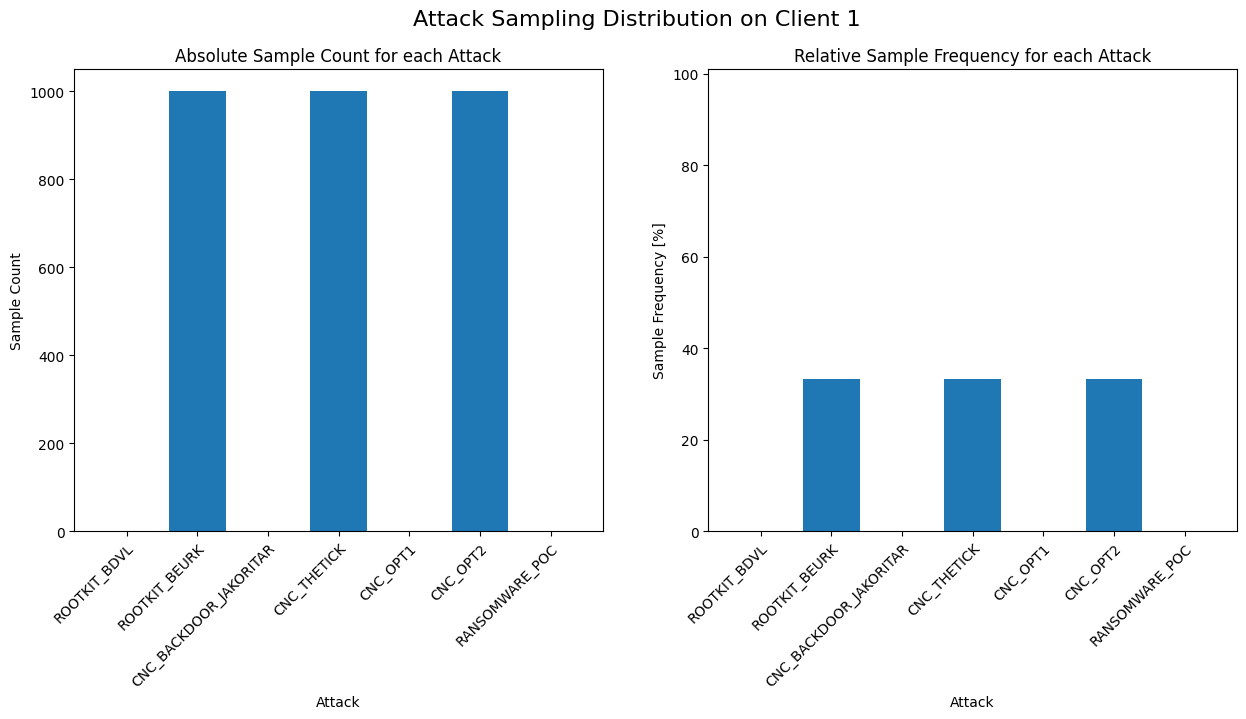

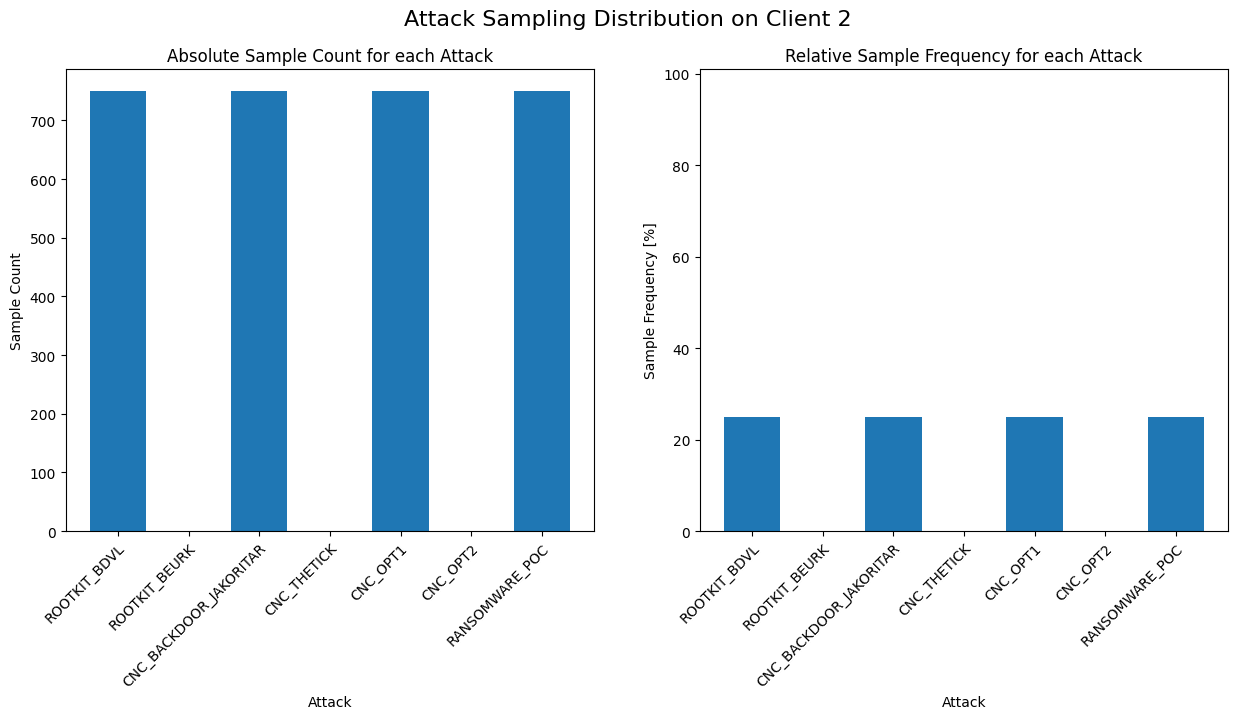

In [ ]:
p2e3v3.plot_sampling_distributions()

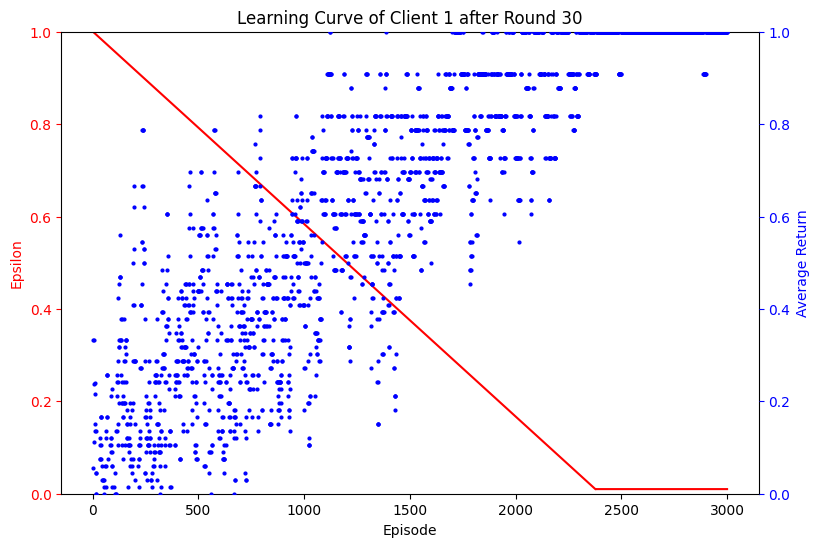

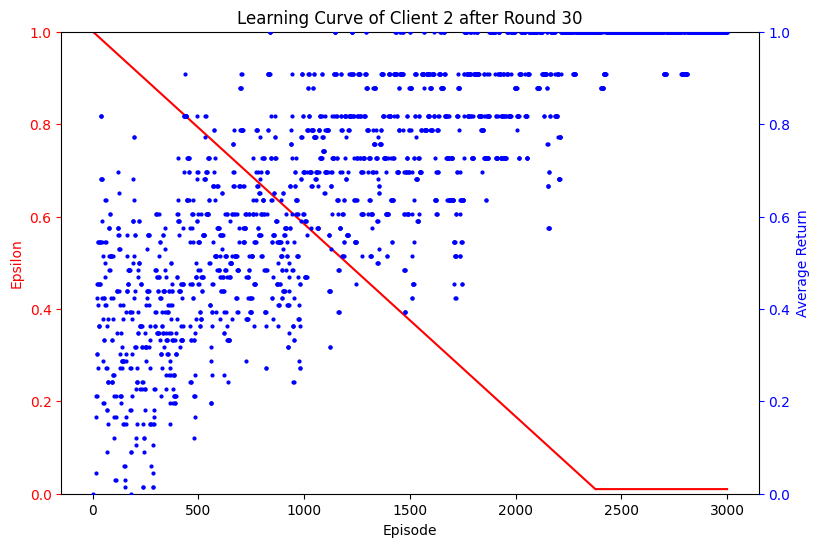

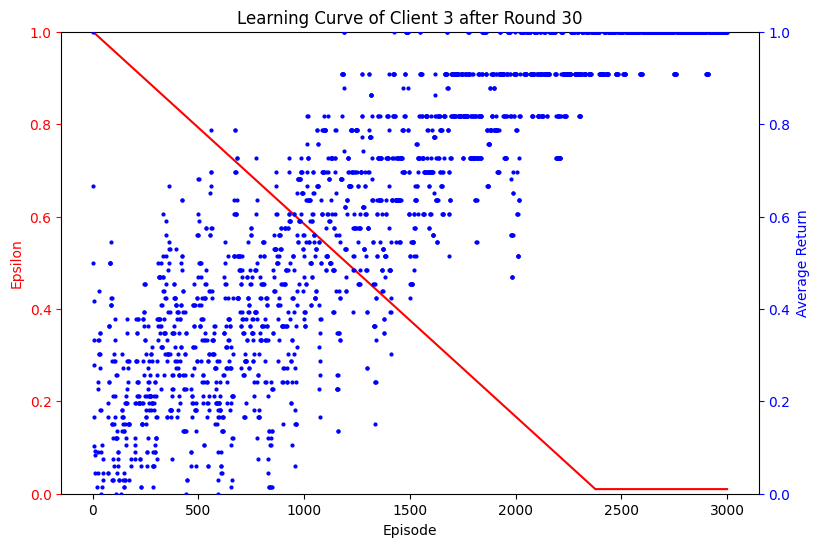

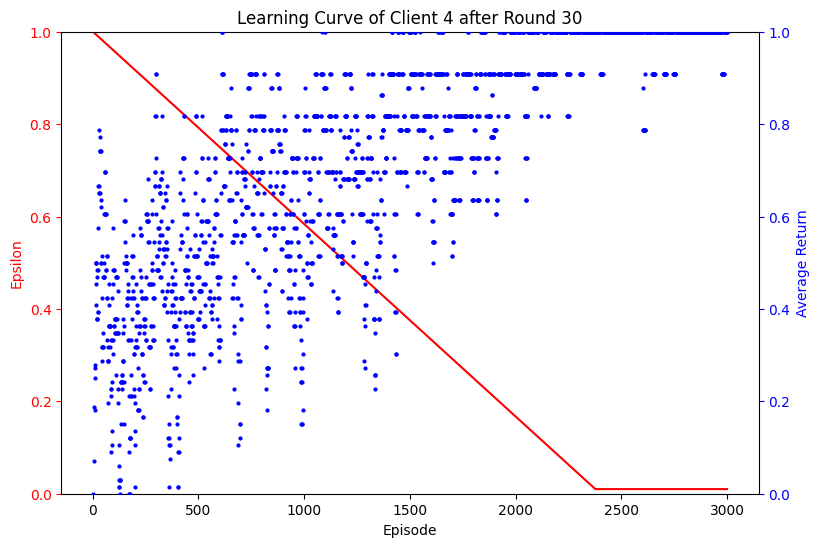

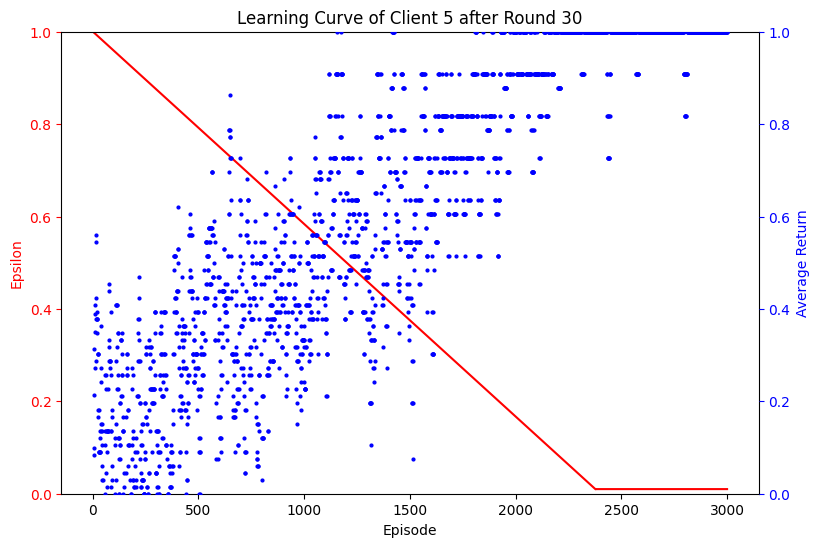

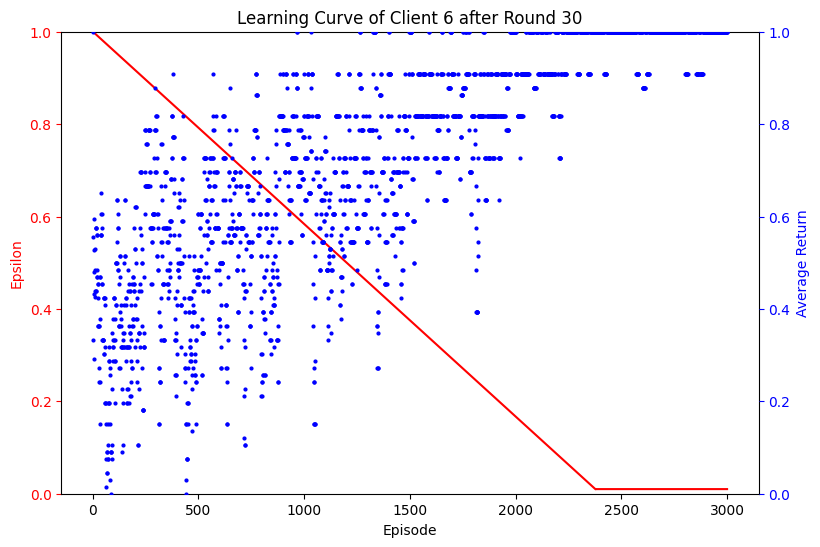

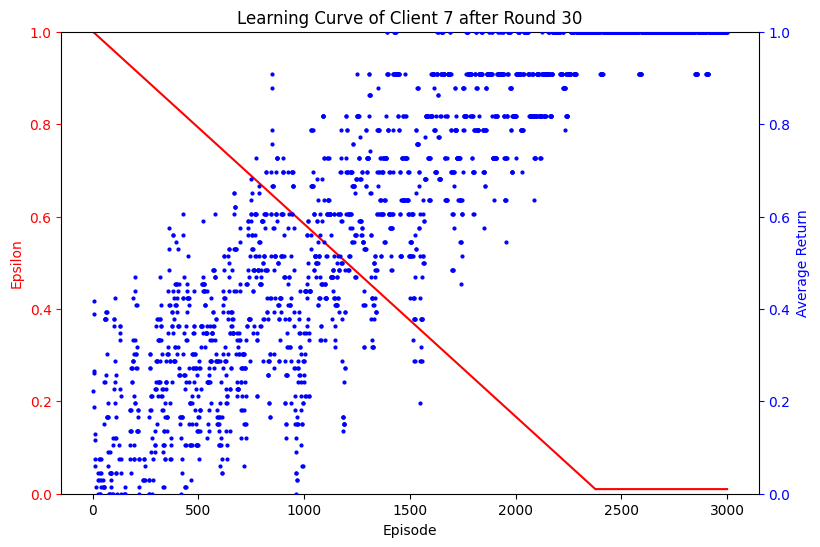

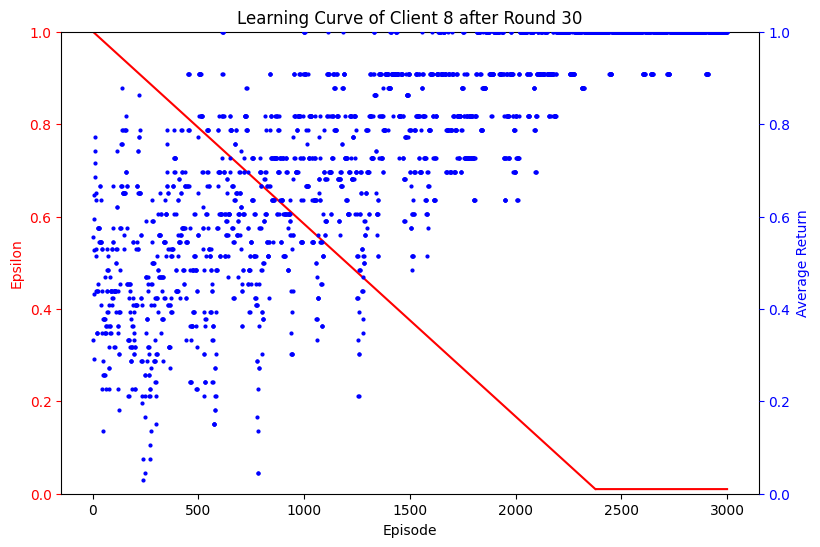

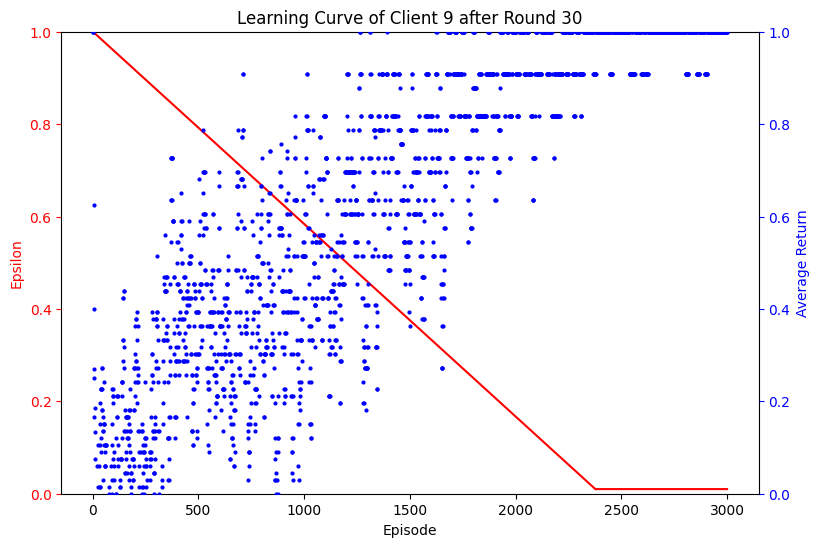

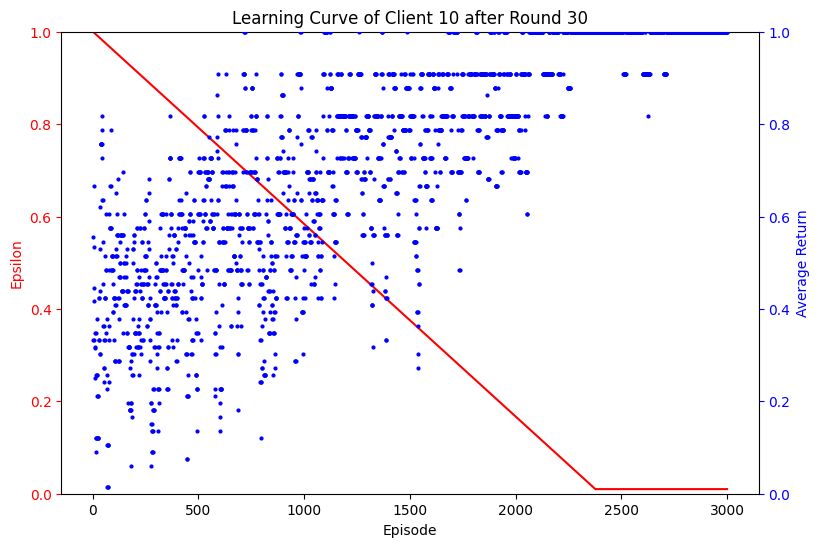

In [ ]:
p2e3v3.show_learning_curves()

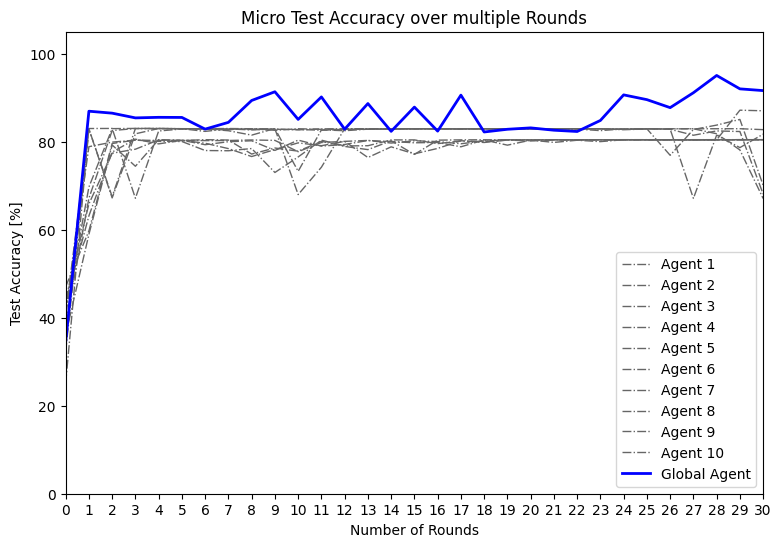

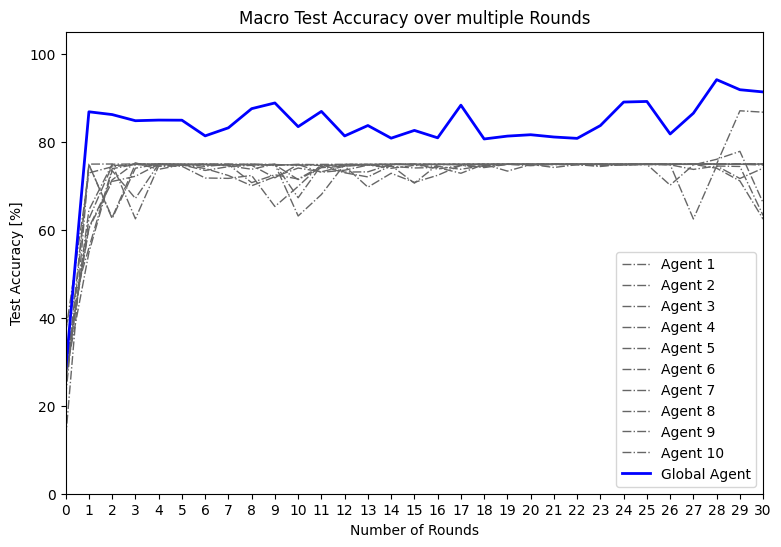

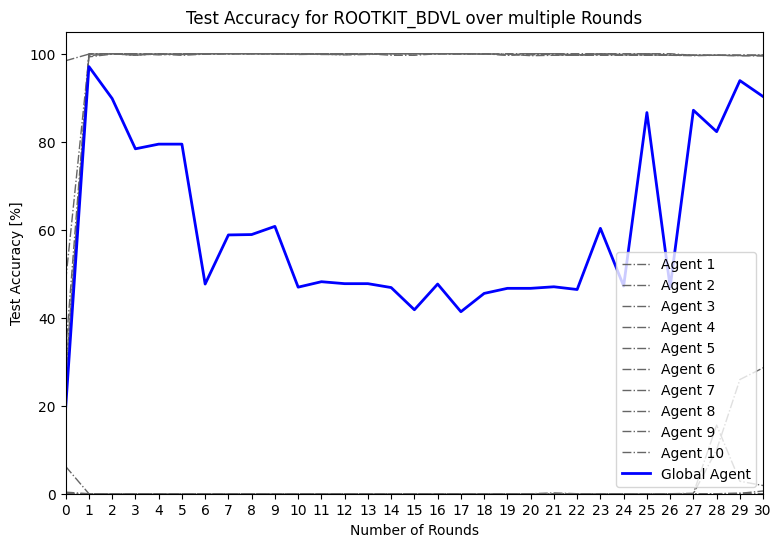

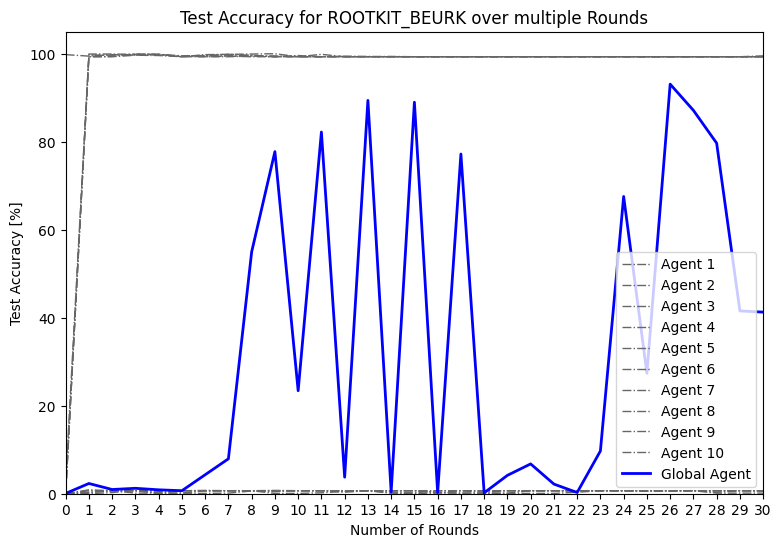

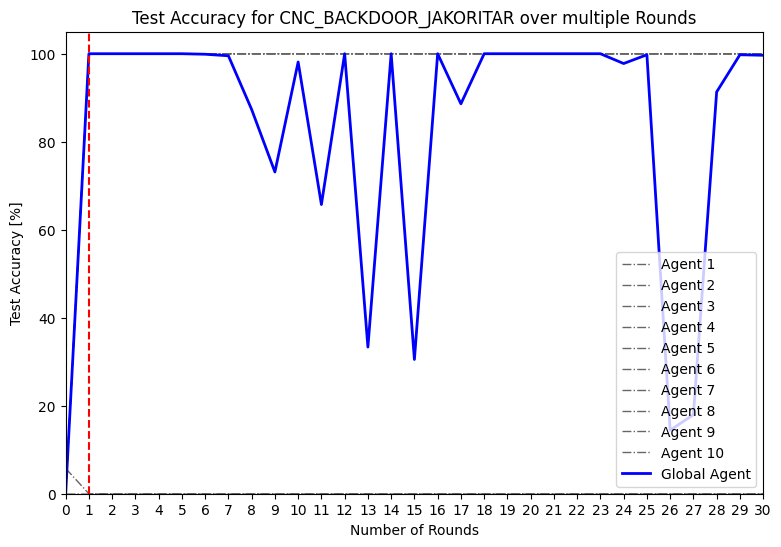

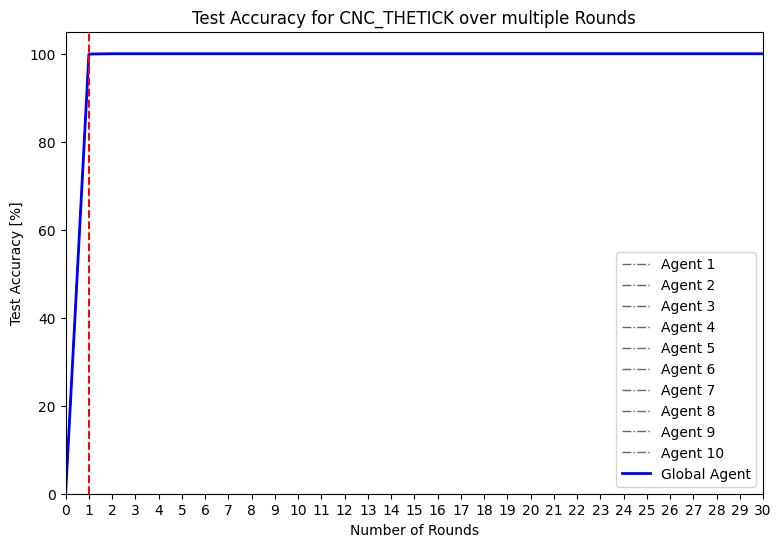

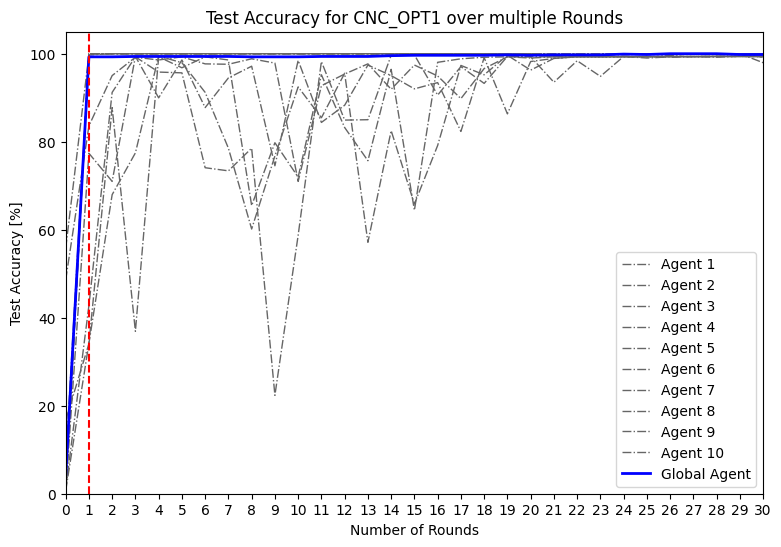

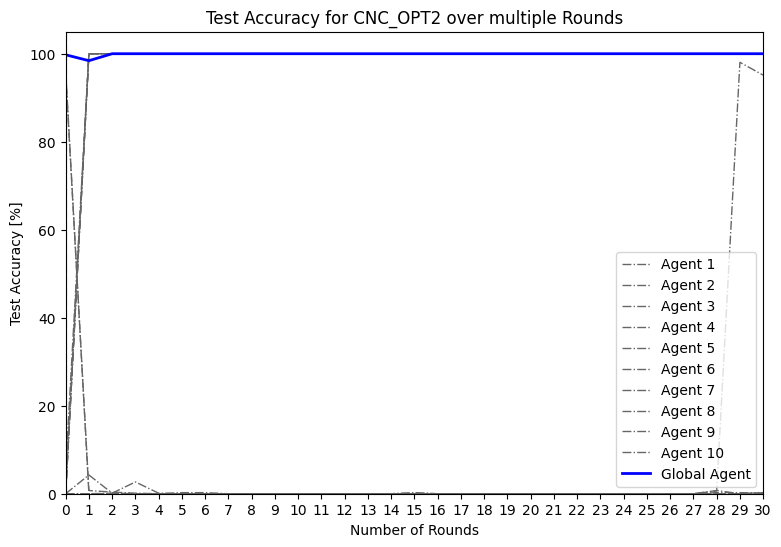

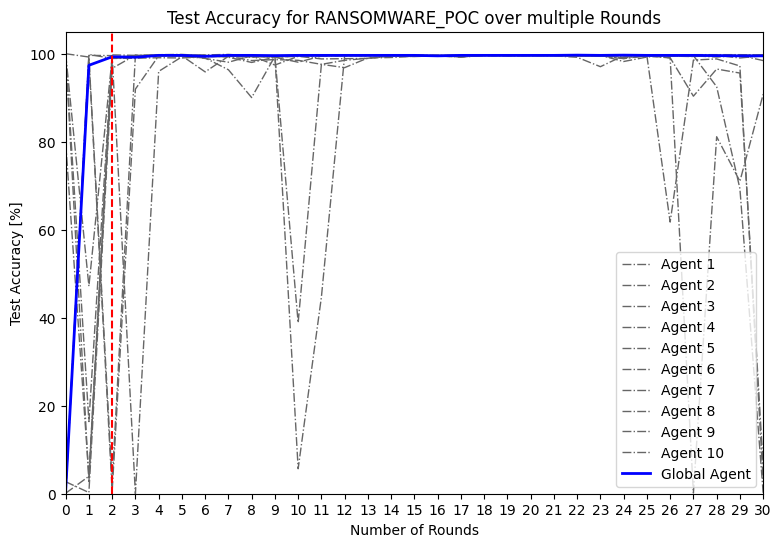

In [ ]:
p2e3v3.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=False)

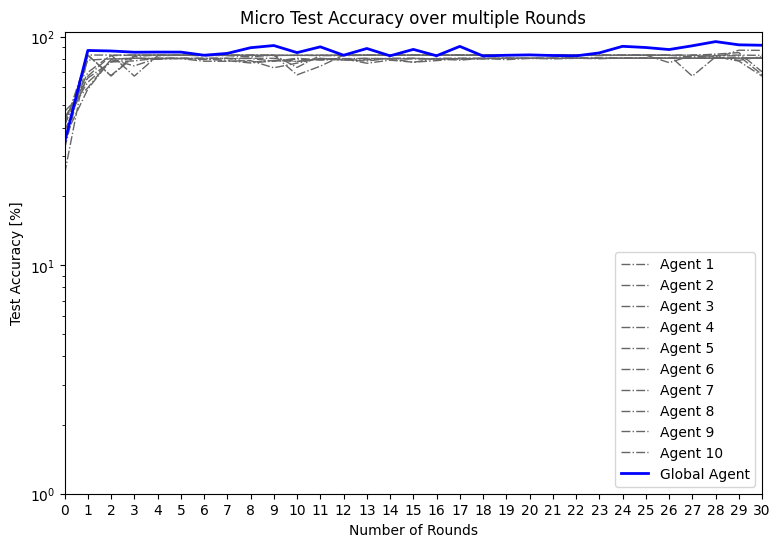

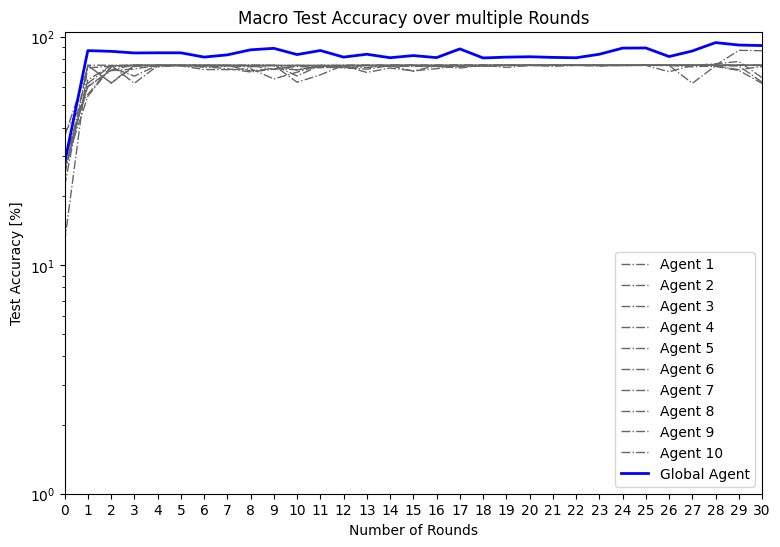

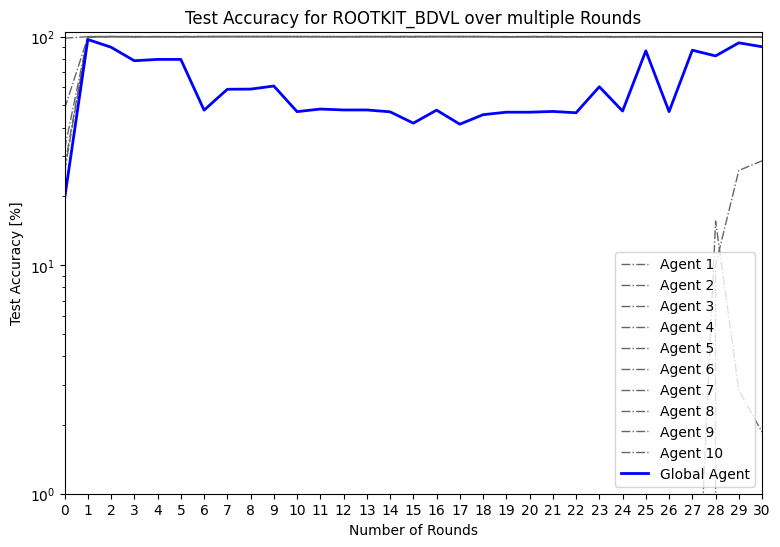

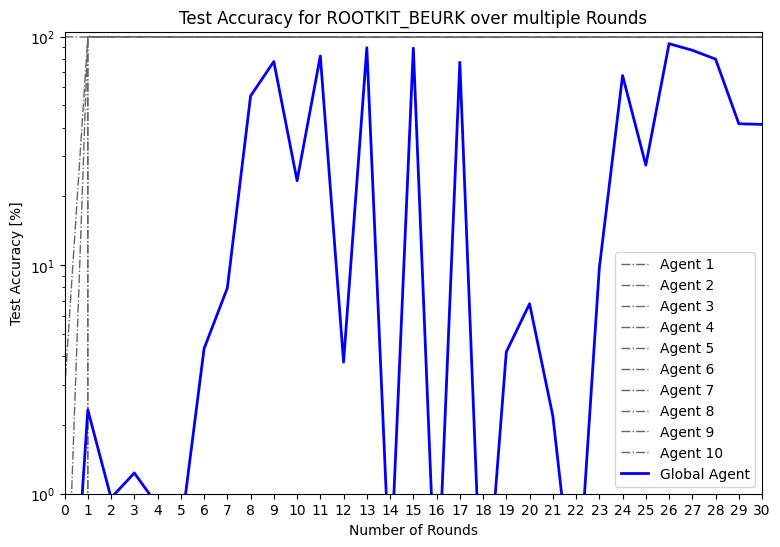

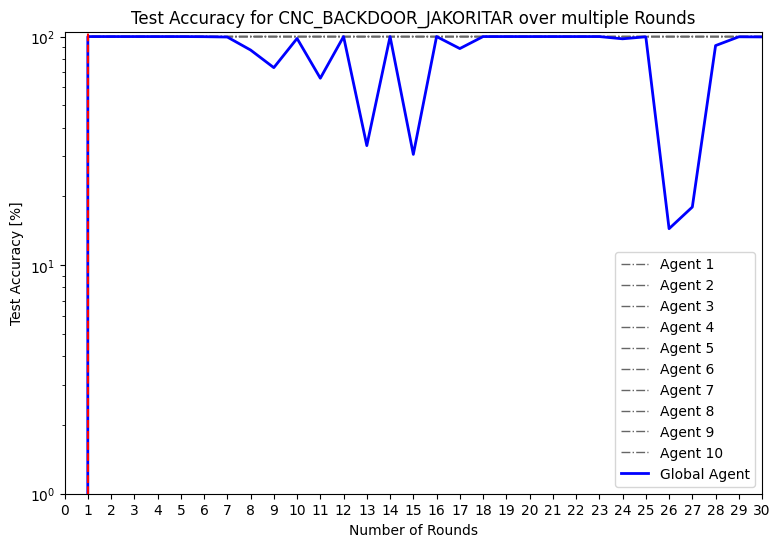

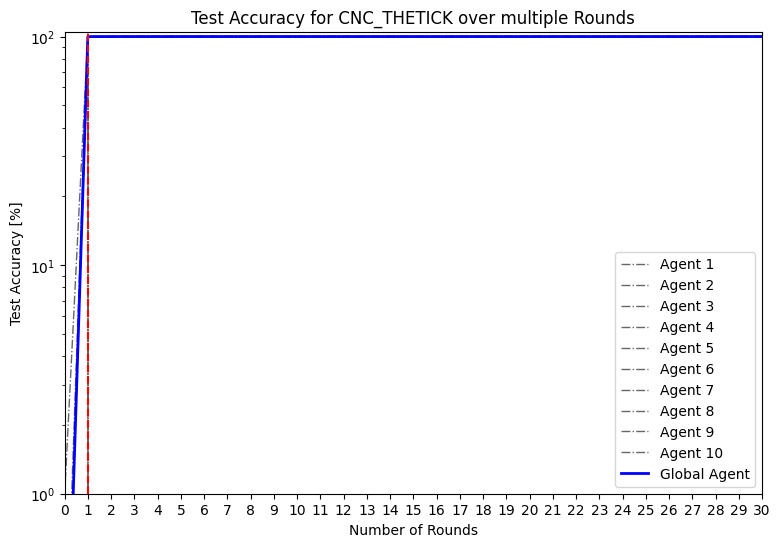

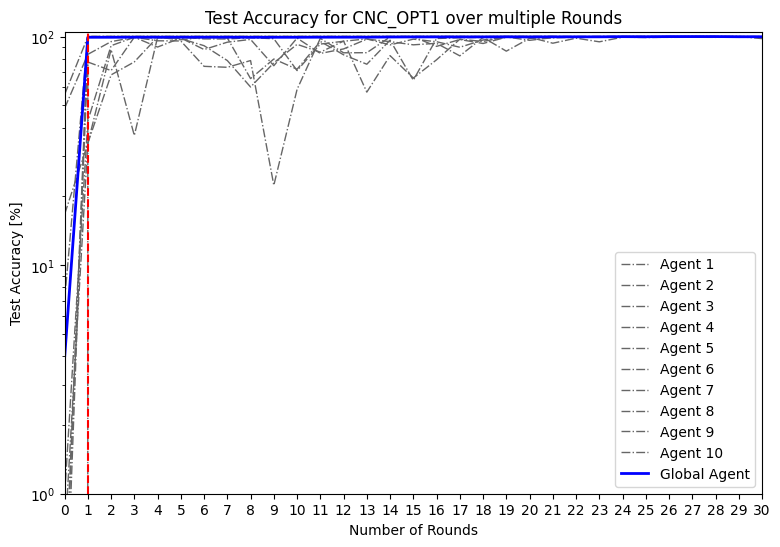

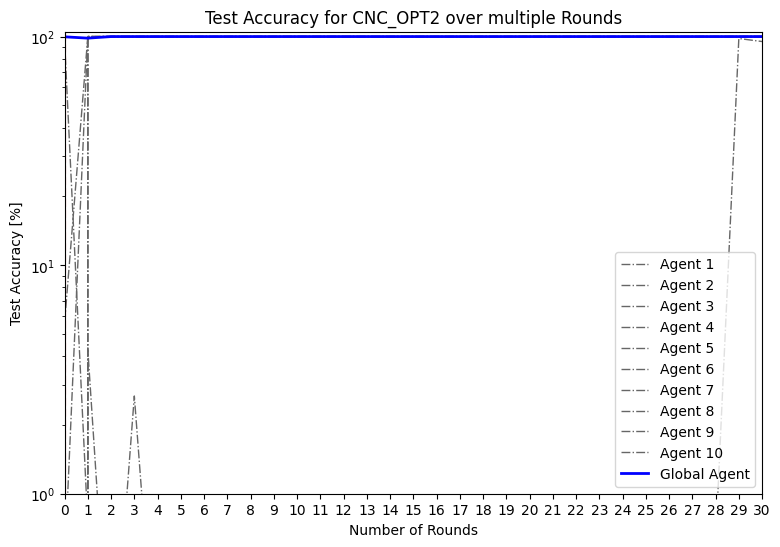

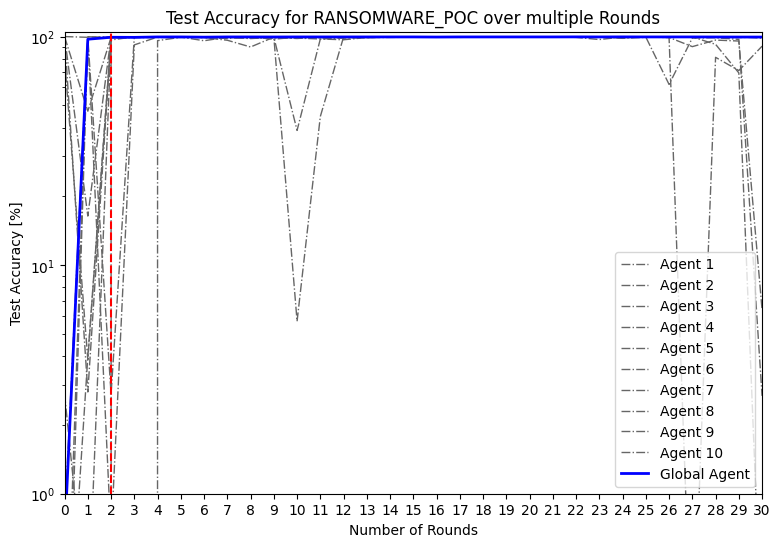

In [23]:
p2e3v3.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=True)